In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,MinMaxScaler, Normalizer
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA,TruncatedSVD

import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## A Tale of Two Cities

![](https://community.drivendata.org/uploads/default/original/1X/4c3a8204d1715b5e2ee24da78abbad1515eccd5f.png)

This dataset has two cities in it: San Juan, Puerto Rico (right) and Iquitos, Peru (left). Since we hypothesize that the spread of dengue may follow different patterns between the two, we will divide the dataset, train seperate models for each city, and then join our predictions before making our final submission.

# Raw Data

In [2]:
features_train_raw = pd.read_csv("dengue_features_train.csv")
features_test_raw = pd.read_csv("dengue_features_test.csv")
labels_train_raw = pd.read_csv("dengue_labels_train.csv")

In [3]:
features_train_raw.head()

city  year  ...  station_min_temp_c station_precip_mm
0   sj  1990  ...                20.0              16.0
1   sj  1990  ...                22.2               8.6
2   sj  1990  ...                22.8              41.4
3   sj  1990  ...                23.3               4.0
4   sj  1990  ...                23.9               5.8

[5 rows x 24 columns]

In [4]:
labels_train_raw.head()

city  year  weekofyear  total_cases
0   sj  1990          18            4
1   sj  1990          19            5
2   sj  1990          20            4
3   sj  1990          21            3
4   sj  1990          22            6

##### To view a complete dataset, i will join the labels to features

In [5]:
whole_data = features_train_raw.merge(labels_train_raw, on = ["city", "year", "weekofyear"])
whole_data.shape

(1456, 25)

# 1 Data Exploration

In [6]:
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

As we can see here, the features are mostly numeric. i will consider "City" and "year" and "week of year" to be categorical and "week_start_date" to be a date time feature.

## 1.1 Analysing Null 

Text(0.5, 0, 'Null Proportions')

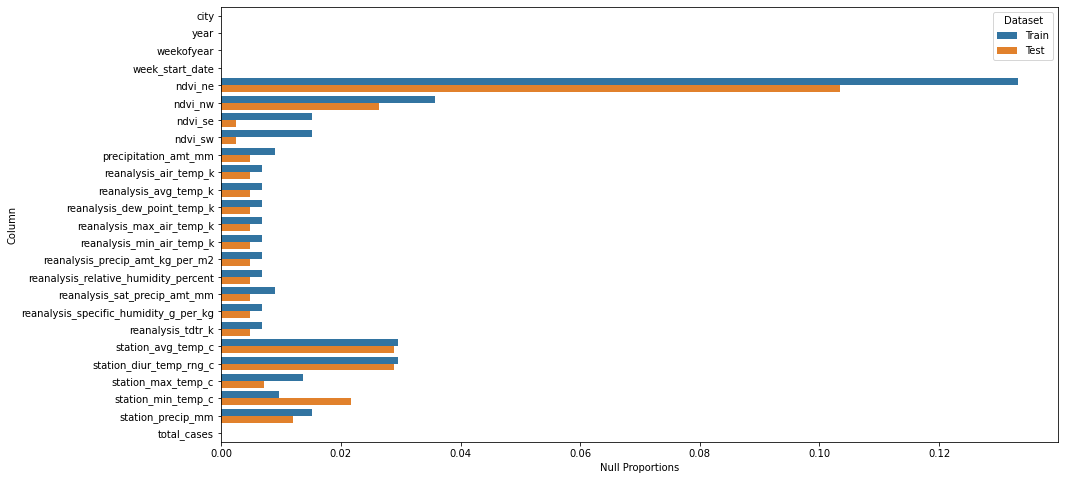

In [7]:
null_df = pd.DataFrame([(len(whole_data) - whole_data.count()) / len(whole_data) , (len(features_test_raw) - features_test_raw.count()) / len(features_test_raw)]).transpose().reset_index()
null_df.rename({"index" : "Column", 0:"Train", 1: "Test"}, axis = 1, inplace = True)
null_df = pd.melt(null_df, id_vars=["Column"], value_vars = ["Train", "Test"]).rename({"variable": "Dataset"}, axis = 1)

fig,ax = plt.subplots(figsize = (15,8))
sns.barplot(x="value", y= "Column", hue="Dataset", data=null_df, orient = "h", ax = ax)
plt.xlabel("Null Proportions")

It can be seen that across the train and test sets, the null values are evenly distributed. The feature which stands out the most will be ndvi_ne. More investigation will be done.

In [8]:
pd.isnull(whole_data).sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

This count further proof that ndvi_ne has a significant amount of null values with about 13% of it being null/NaN

count    1262.000000
mean        0.142294
std         0.140531
min        -0.406250
25%         0.044950
50%         0.128817
75%         0.248483
max         0.508357
Name: ndvi_ne, dtype: float64
count    1404.000000
mean        0.130553
std         0.119999
min        -0.456100
25%         0.049217
50%         0.121429
75%         0.216600
max         0.454429
Name: ndvi_nw, dtype: float64
count    1434.000000
mean        0.203783
std         0.073860
min        -0.015533
25%         0.155087
50%         0.196050
75%         0.248846
max         0.538314
Name: ndvi_se, dtype: float64
count    1434.000000
mean        0.202305
std         0.083903
min        -0.063457
25%         0.144209
50%         0.189450
75%         0.246982
max         0.546017
Name: ndvi_sw, dtype: float64


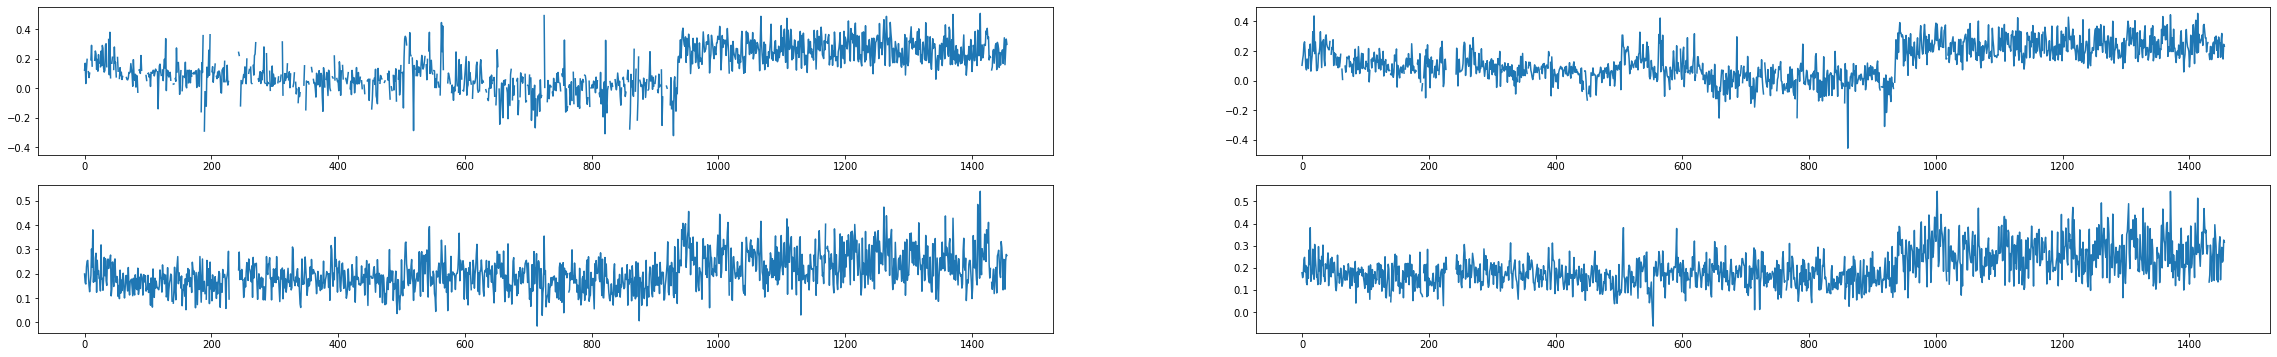

In [9]:
plt.subplot(2,2,1)
whole_data.ndvi_ne.plot(figsize =(40,6))
plt.subplot(2,2,2)
whole_data.ndvi_nw.plot(figsize =(40,6))
plt.subplot(2,2,3)
whole_data.ndvi_se.plot(figsize =(40,6))
plt.subplot(2,2,4)
whole_data.ndvi_sw.plot(figsize =(40,6))
print(whole_data.ndvi_ne.describe())
print(whole_data.ndvi_nw.describe())
print(whole_data.ndvi_se.describe())
print(whole_data.ndvi_sw.describe())

However since the data are all pretty stable, i believe there should still be some form of correlation to the total number of cases and hence should be imputed instead of removed.

## 1.2 Analysing features between SJ and IQ

In [10]:
numeric = whole_data.select_dtypes(include = "float64")
print(numeric.columns)

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')


###1.2.1 Violin Plots

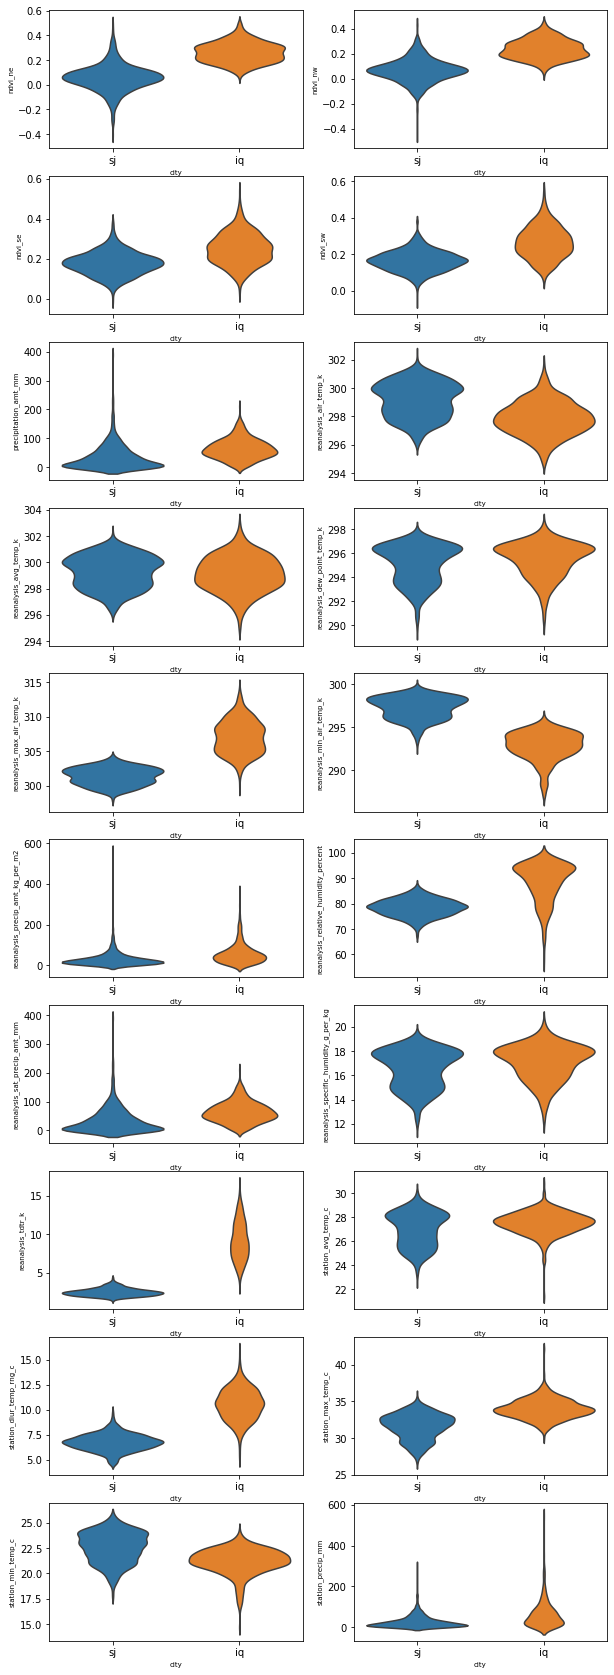

In [11]:
fig, ax = plt.subplots(nrows = 10, ncols=2, figsize = (10,30))
for i,j in enumerate(numeric):
  sns.violinplot("city", j, data=whole_data, inner = None, ax = ax[int(np.floor(i/2)),np.mod(i,2)])
  ax[int(np.floor(i/2)),np.mod(i,2)].yaxis.label.set_size(7)
  ax[int(np.floor(i/2)),np.mod(i,2)].xaxis.label.set_size(7)

It is evident that majority of the features seem to have the same distribution of measurements except for "reanalysis_max_air_temp_k", "reanalysis_relative_humidity_percent", "reanalysis_tdtr_k"..etc.

Text(0, 0.5, 'No Of Cases Per Week')

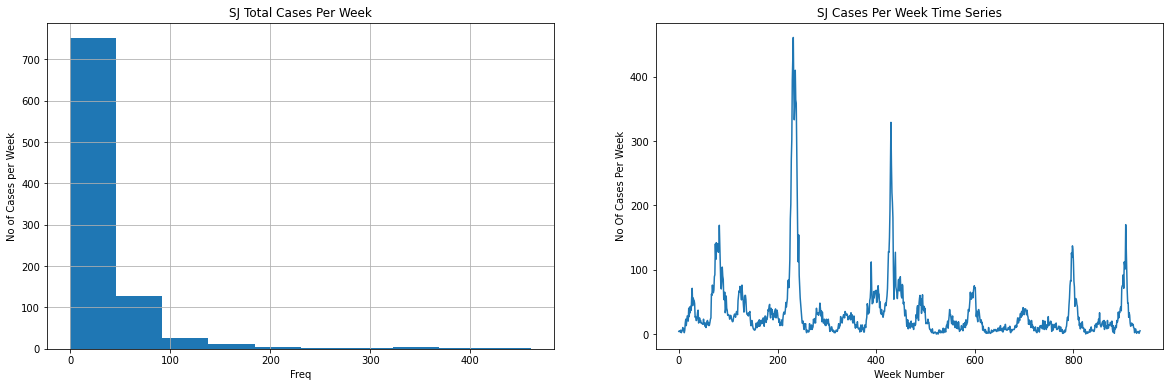

In [12]:
# Exploring SJ data
whole_data_sj = whole_data.loc[whole_data["city"] =="sj"]

plt.subplot(1,2,1)
whole_data_sj.total_cases.hist()
plt.title("SJ Total Cases Per Week")
plt.xlabel("Freq")
plt.ylabel("No of Cases per Week")
plt.subplot(1,2,2)
whole_data_sj.total_cases.plot(figsize =(20,6))
plt.title("SJ Cases Per Week Time Series")
plt.xlabel("Week Number")
plt.ylabel("No Of Cases Per Week")

Text(0, 0.5, 'No Of Cases Per Week')

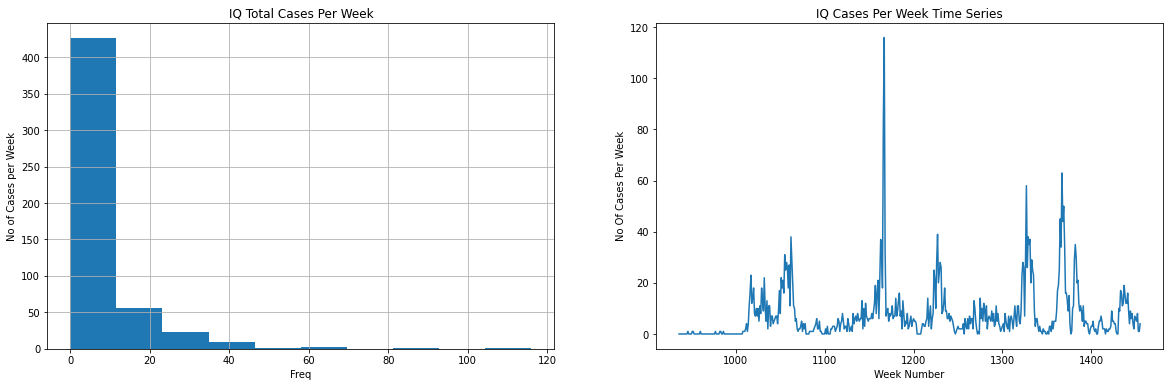

In [13]:
# Exploring IQ data
whole_data_iq = whole_data.loc[whole_data["city"] =="iq"]

plt.subplot(1,2,1)
whole_data_iq.total_cases.hist()
plt.title("IQ Total Cases Per Week")
plt.xlabel("Freq")
plt.ylabel("No of Cases per Week")
plt.subplot(1,2,2)
whole_data_iq.total_cases.plot(figsize =(20,6))
plt.title("IQ Cases Per Week Time Series")
plt.xlabel("Week Number")
plt.ylabel("No Of Cases Per Week")

As seen, SJ have several peaks in cases in 1995,1999 and 2006,2008 while IQ has the highest peak in 2005,2008 and 2009

Looking at both cities, it is evident that the total cases contain very different data. This emphasises the need to analyse and build models for each city separately

### 1.2.3 Correlation Heatmap

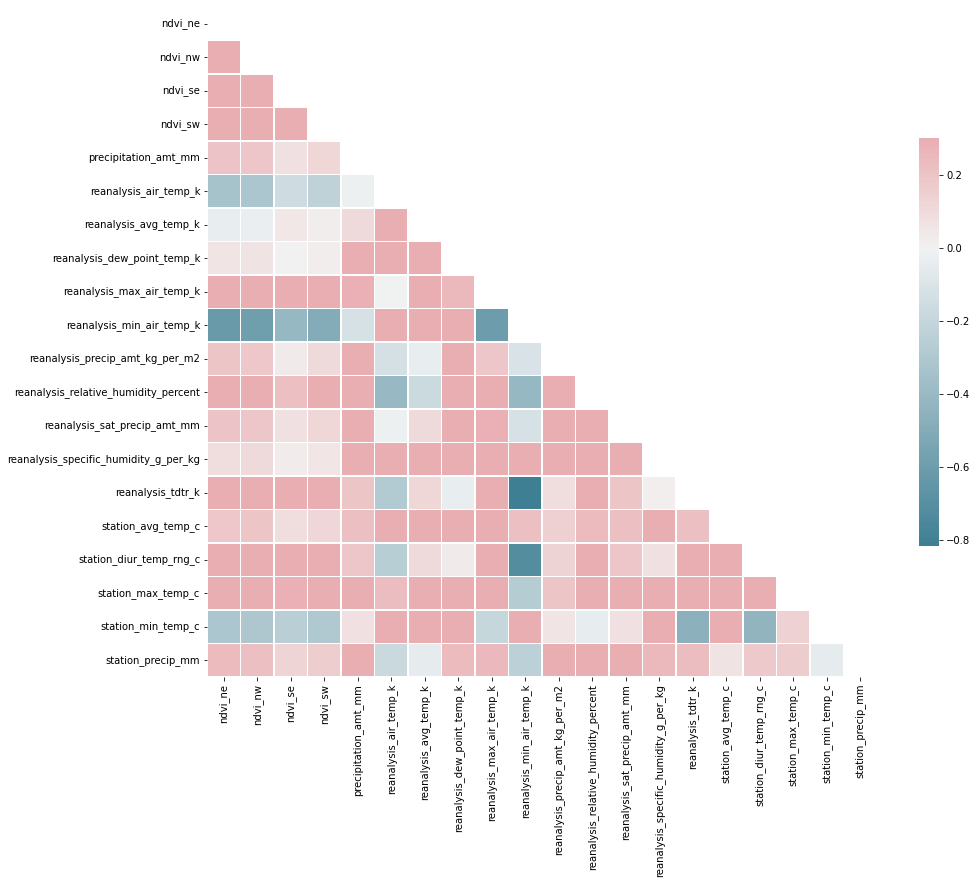

In [14]:
corr = numeric.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize = (15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data = corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#1.2.4 Descriptive Analysis

In [15]:
features_train_raw.groupby("city").mean()

year  weekofyear  ...  station_min_temp_c  station_precip_mm
city                           ...                                       
iq    2005.000000   26.503846  ...           21.196680          62.467262
sj    1998.826923   26.503205  ...           22.600645          26.785484

[2 rows x 22 columns]

In [16]:
features_test_raw.groupby("city").mean()

year  weekofyear  ...  station_min_temp_c  station_precip_mm
city                           ...                                       
iq    2011.500000   26.333333  ...           21.089262          34.389542
sj    2010.326923   26.503846  ...           23.107364          34.212791

[2 rows x 22 columns]

From all the above analysis, it can be seen that the 2 cities have quite different data but the general trend is similar in both the test and train datasets.

I am hypothesising that the difference in the distributions of the variables is because of the location of these 2 regions, 1 being in the northern hemisphere while the other in the south.

According to the various plots, it can be seen that distribution relating to vegetation, humidity, temperature and precipitation are almost polar behaviours with respect to the weeks of the year. 

This further supports my claim.

**Therefore, i have decided to treat the 2 cities separately and fit the models separately as well.**


In [17]:
features_train_raw_sj = features_train_raw[features_train_raw.city == "sj"].drop("city",1)
features_train_raw_iq = features_train_raw[features_train_raw.city == "iq"].drop("city",1)
features_test_raw_sj = features_test_raw[features_test_raw.city == "sj"].drop("city",1)
features_test_raw_iq = features_test_raw[features_test_raw.city == "iq"].drop("city",1)

In [18]:
(len(features_train_raw_sj),len(features_test_raw_sj))

(936, 260)

In [19]:
(len(features_train_raw_iq),len(features_test_raw_iq))

(520, 156)

The train and test dataset will be combined to look for outlier and smoothing out the general data.

In [20]:
# merge_sj = pd.concat([features_test_raw_sj, features_train_raw_sj], ignore_index = True)
# merge_iq = pd.concat([features_test_raw_iq, features_train_raw_iq], ignore_index = True)

In [21]:
features_train_raw_iq.shape

(520, 23)

In [22]:
# IQ null counts
features_train_raw_iq.isnull().sum()

year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                   3
ndvi_nw                                   3
ndvi_se                                   3
ndvi_sw                                   3
precipitation_amt_mm                      4
reanalysis_air_temp_k                     4
reanalysis_avg_temp_k                     4
reanalysis_dew_point_temp_k               4
reanalysis_max_air_temp_k                 4
reanalysis_min_air_temp_k                 4
reanalysis_precip_amt_kg_per_m2           4
reanalysis_relative_humidity_percent      4
reanalysis_sat_precip_amt_mm              4
reanalysis_specific_humidity_g_per_kg     4
reanalysis_tdtr_k                         4
station_avg_temp_c                       37
station_diur_temp_rng_c                  37
station_max_temp_c                       14
station_min_temp_c                        8
station_precip_mm               

In [23]:
#SJ null counts
features_train_raw_sj.isnull().sum()

year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_min_temp_c                         6
station_pr

Text(0.5, 1.0, 'SJ correlation')

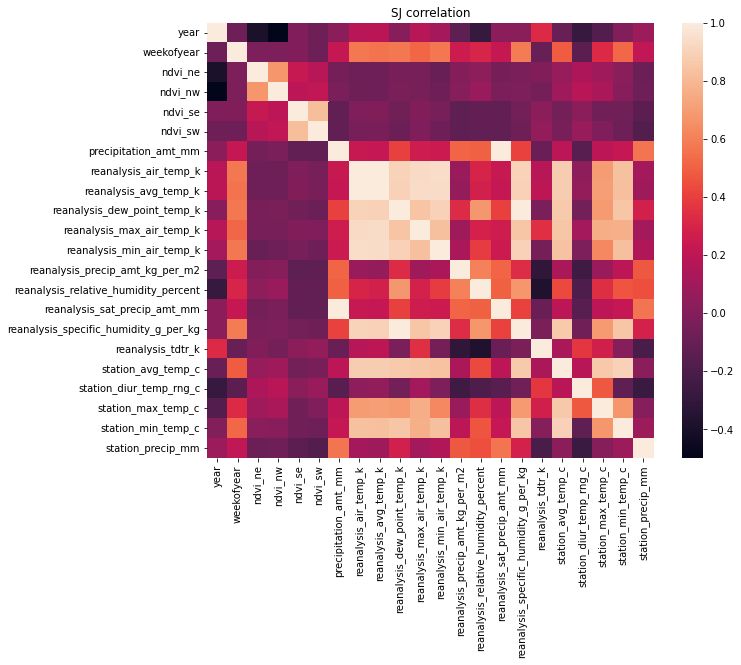

In [24]:
plt.figure(figsize=(10,8))
corr_sj = sns.heatmap(features_train_raw_sj.corr())
plt.title("SJ correlation")

Text(0.5, 1.0, 'IQ correlation')

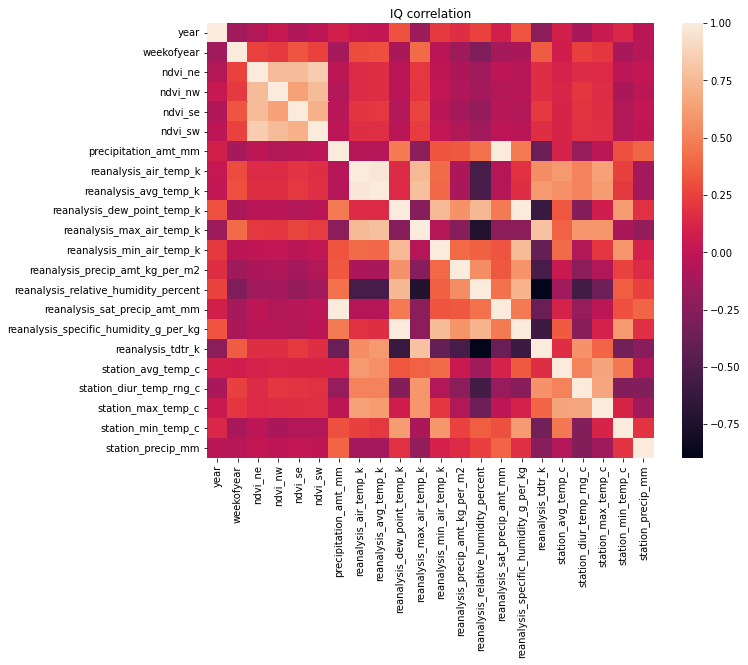

In [25]:
plt.figure(figsize=(10,8))
corr_iq = sns.heatmap(features_train_raw_iq.corr())
plt.title("IQ correlation")

By testing the cross-correlation among features, we are able to identify repeated features and identify features that can be further processed by reduction.

In SJ, it can be seen that the temperature features have a generally good correlation while in IQ NDVI and humidity shows a realtively good correlation.

The correlation matric shows highly correlated features for both regions and will be removed in the training and test sets, to avoid potential data leakage.

# 2 Data Preprocessing

As this dataset have alot of features, and some of the features are quite similar, i will drop columns with >95% similarity so only one is used.

In [26]:
upper_triangle = (features_train_raw_iq.corr()).where(np.triu(np.ones(features_train_raw_iq.corr().shape), k=1).astype(np.bool))

col_to_drop_iq = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95) | any(upper_triangle[col] < -0.95)]
print(col_to_drop_iq)

['reanalysis_avg_temp_k', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg']


In [27]:
upper_triangle = (features_train_raw_sj.corr()).where(np.triu(np.ones(features_train_raw_sj.corr().shape), k=1).astype(np.bool))

col_to_drop_sj = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95) | any(upper_triangle[col] < -0.95)]
print(col_to_drop_sj)

['reanalysis_avg_temp_k', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg']


In [28]:
features_train_raw_sj.drop(col_to_drop_sj, axis = 1, inplace=True)
features_train_raw_iq.drop(col_to_drop_iq,axis=1, inplace = True)

Additionally, since there are 3 variables indicating the time - week_start_date, year and weekofyear. i will drop year as it is too vague. Weekofyear will be kept as an indicator of the seasons.

In [29]:
features_train_raw_sj.drop("year", axis = 1, inplace=True)
features_train_raw_iq.drop("year",axis=1, inplace = True)

In [30]:
features_train_raw_iq.columns

Index(['weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

##2.1 Preprocessing Temperature

For simplicity sake, i will convert the temperature to celcius

In [31]:
features_train_raw_sj[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']] -= 273.15
features_train_raw_iq[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']] -= 273.15


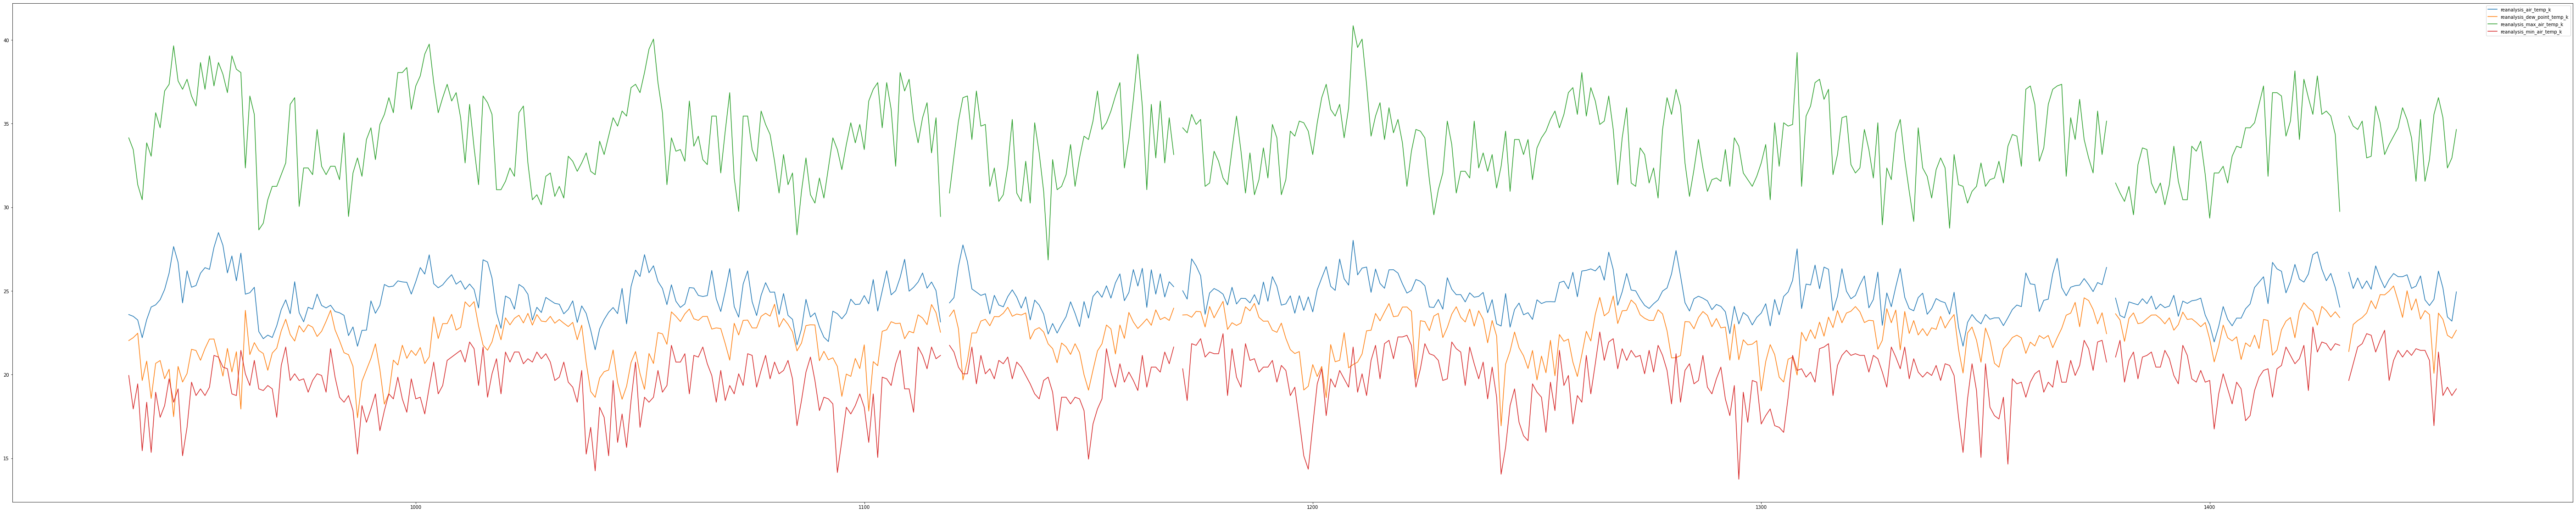

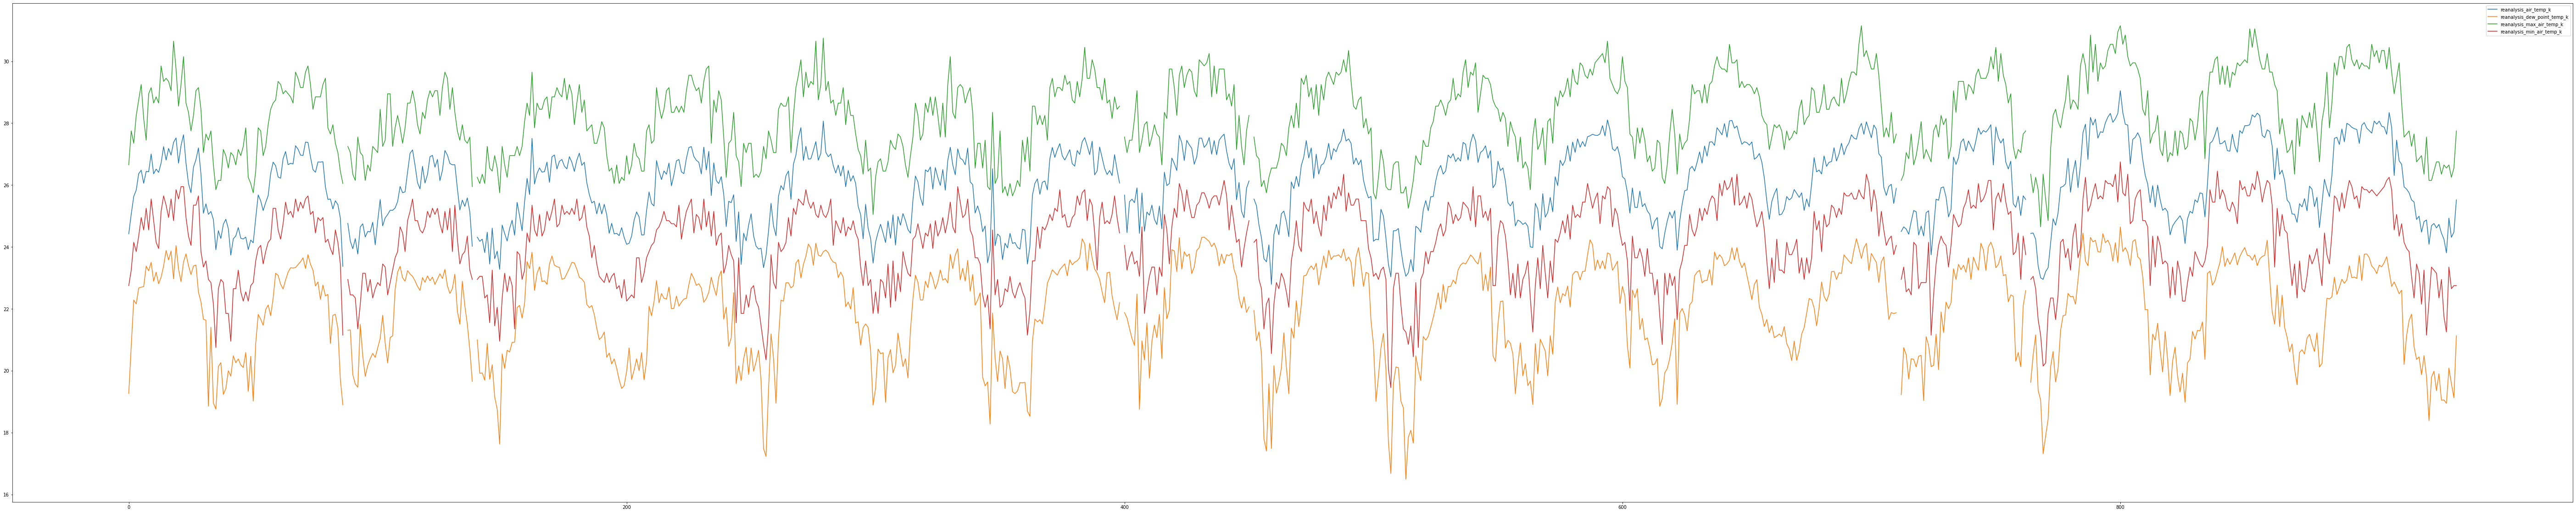

In [32]:
features_train_raw_iq[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 
            'reanalysis_min_air_temp_k']].plot(figsize=(100, 20))
features_train_raw_sj[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 
            'reanalysis_min_air_temp_k']].plot(figsize=(100, 20))

For the temperature data, we will leave IQ as such without applying reduction. But for SJ we shall take the mean and reduce it to 1 temperature feature since they all show similar visual patterns

In [33]:
features_train_raw_sj["reanalysis_temp_c"] = features_train_raw_sj[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k']].mean(axis=1)
features_train_raw_sj.drop(['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k'], axis=1, inplace=True)

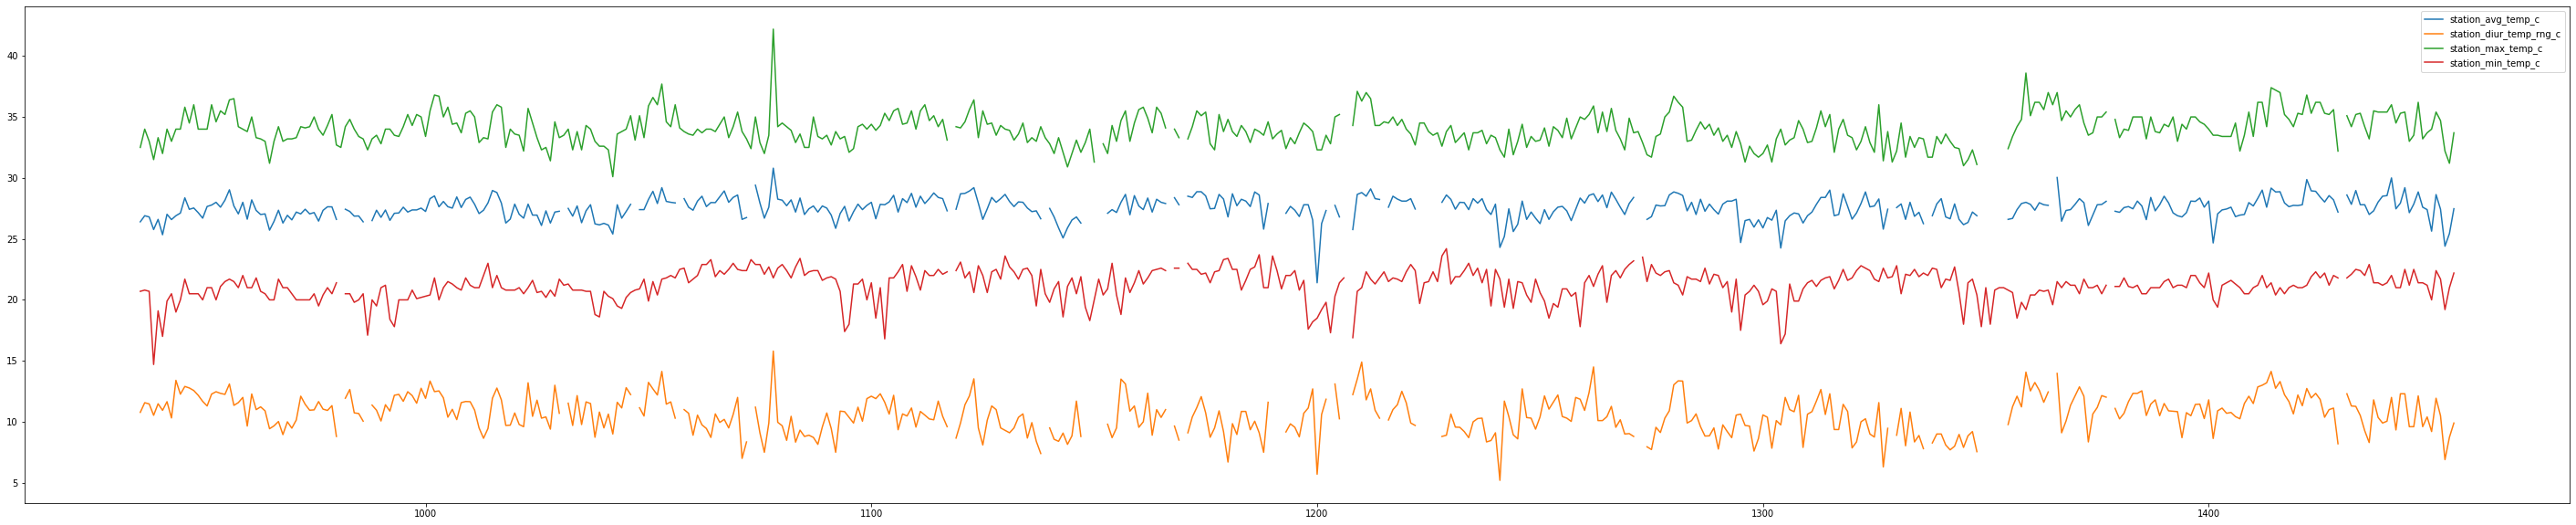

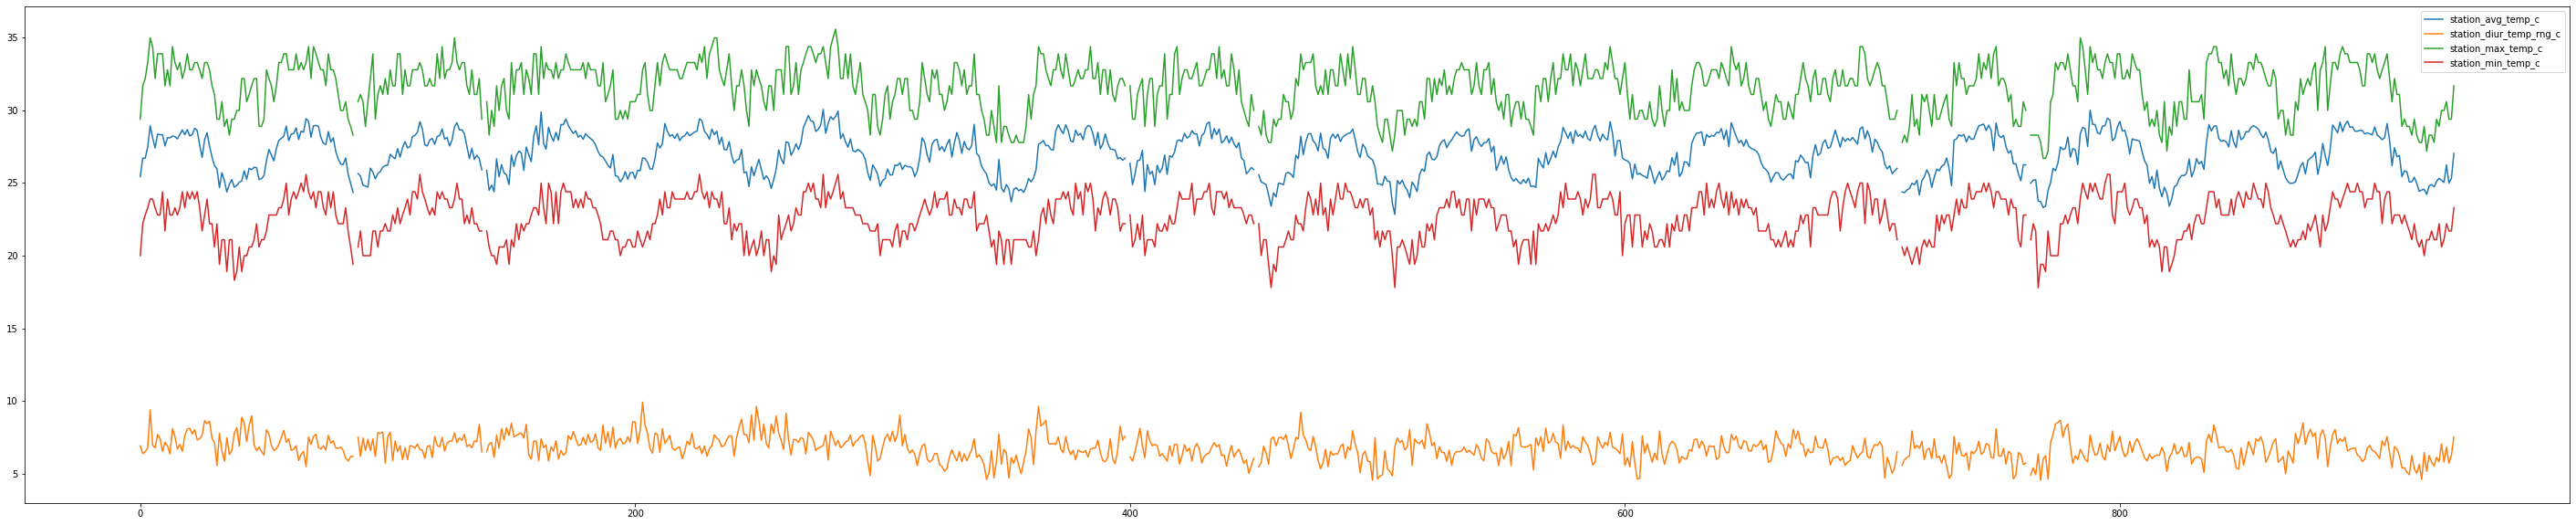

In [34]:
features_train_raw_iq[['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c']].plot(figsize=(50, 10))
features_train_raw_sj[['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c']].plot(figsize=(50, 10))

Based on the figure, avg, max and min seems to be related. Also, there apears to be missing datas.Hence we will reduce it to 1 feature by taking the mean after interpolation. Diurnal doesnt seem to have much use to the result and hence shall be dropped.

In [35]:
features_train_raw_iq['station_temp_c'] = features_train_raw_iq[['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']].interpolate().mean(axis=1)
features_train_raw_iq.drop(['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1, inplace=True)


features_train_raw_sj['station_temp'] = features_train_raw_sj[['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']].interpolate().mean(axis=1)
features_train_raw_sj.drop(['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1, inplace=True)

In [36]:
features_train_raw_sj.columns

Index(['weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_tdtr_k',
       'station_precip_mm', 'reanalysis_temp_c', 'station_temp'],
      dtype='object')

In general, Station temperatures for both region are pretty similar. The average temperatures seem to be influenced by the maximum and minimum where any missing value in either would result in a missing average value

##2.2 Preprocessing NDVI

However for the ndvi data which is broken in the 4 regions, due to the large amount of null values in certain regions, i will be taking the mean of it as a representation.

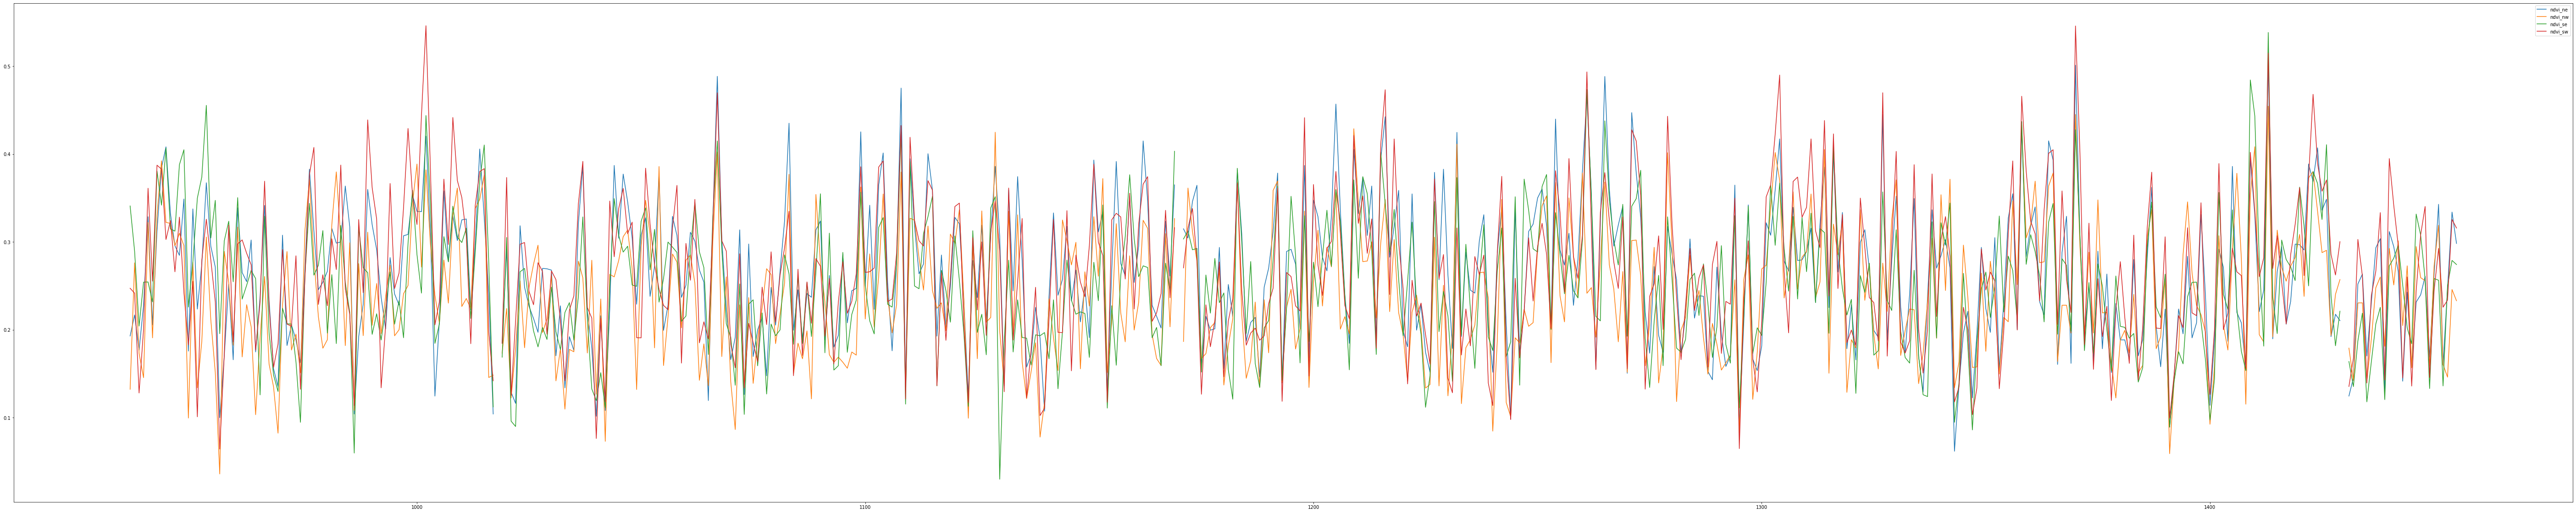

In [37]:
features_train_raw_iq[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].plot(figsize=(100, 20))


For IQ since all 4 regions pretty much overlaps, i will take the mean of all 4.

In [38]:
features_train_raw_iq["ndvi"] = features_train_raw_iq[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].mean(axis=1)
features_train_raw_iq.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis = 1, inplace = True)



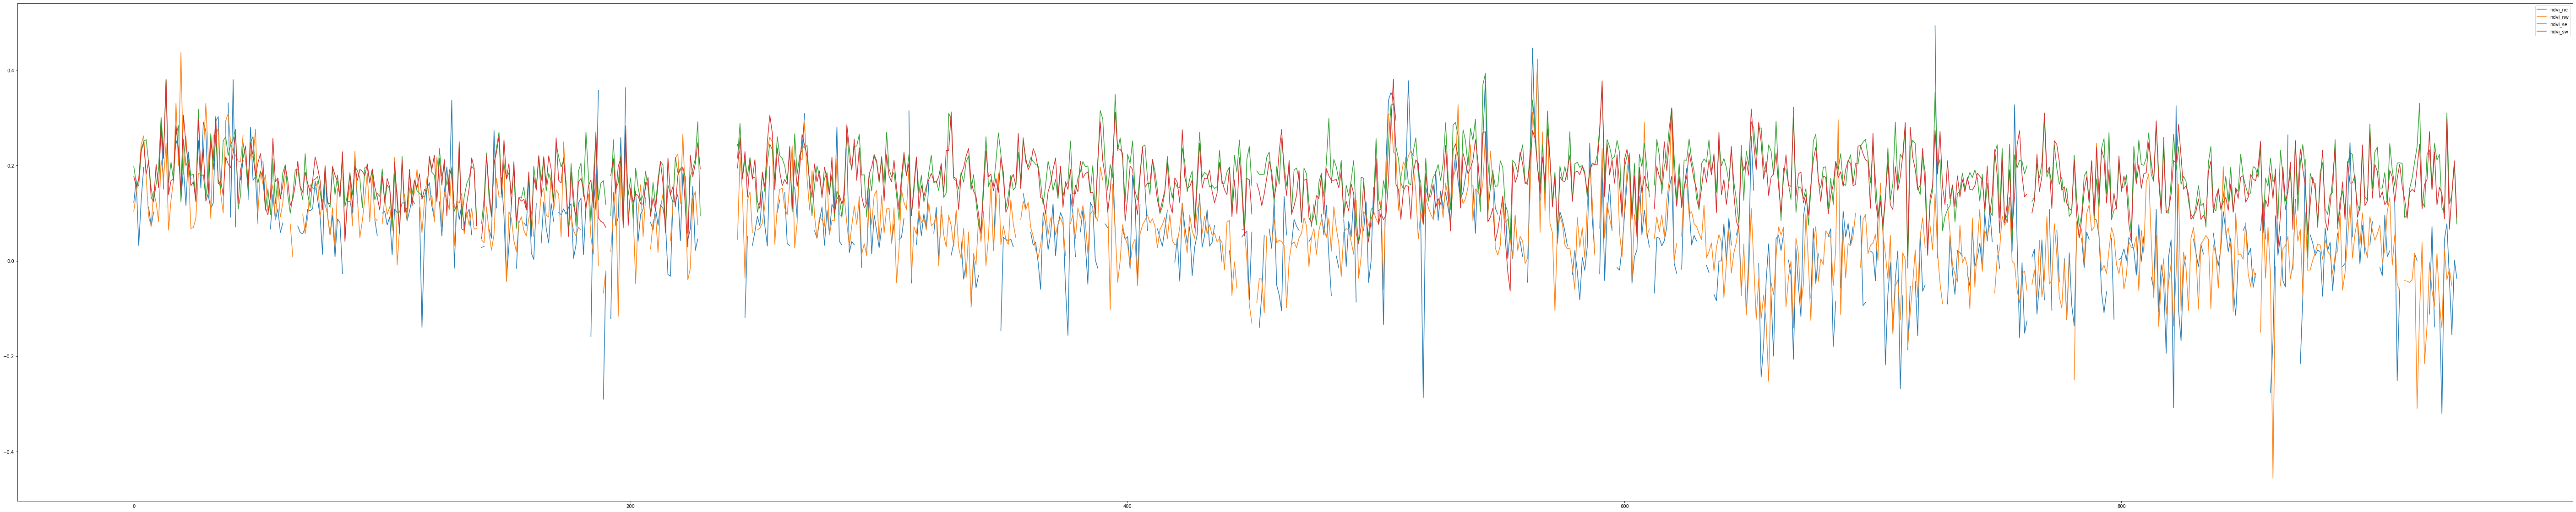

In [39]:
features_train_raw_sj[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].plot(figsize=(100, 20))


For SJ, there seem to be a difference between the north and south regions, hence i will break it into 2 regions

In [40]:
features_train_raw_sj['ndvi_n'] = features_train_raw_sj[['ndvi_ne', 'ndvi_nw']].mean(axis=1)
features_train_raw_sj['ndvi_s'] = features_train_raw_sj[['ndvi_se', 'ndvi_sw']].mean(axis=1)
features_train_raw_sj.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis=1, inplace=True)

##2.3 Preprocessing Train Labels

In [41]:
labels_train_raw.drop("year", axis = 1, inplace=True)
labels_train_raw["week_start_date"] = features_train_raw.week_start_date


In [42]:

labels_train_sj = labels_train_raw[labels_train_raw.city == "sj"].drop(["city", "weekofyear"], axis = 1)
labels_train_iq = labels_train_raw[labels_train_raw.city == "iq"].drop(["city", "weekofyear"], axis = 1)


2.4 Processing Test Data

In [43]:
features_test_raw_sj.drop(col_to_drop_sj, axis = 1, inplace=True)
features_test_raw_iq.drop(col_to_drop_iq, axis = 1, inplace=True)

features_test_raw_sj.drop("year", axis = 1, inplace=True)
features_test_raw_iq.drop("year",axis=1, inplace = True)

features_test_raw_sj[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']] -= 273.15
features_test_raw_iq[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']] -= 273.15

features_test_raw_sj["reanalysis_temp_c"] = features_test_raw_sj[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k']].mean(axis=1)
features_test_raw_sj.drop(['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k'], axis=1, inplace=True)


features_test_raw_iq['station_temp_c'] = features_test_raw_iq[['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']].interpolate().mean(axis=1)
features_test_raw_iq.drop(['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1, inplace=True)


features_test_raw_sj['station_temp'] = features_test_raw_sj[['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']].interpolate().mean(axis=1)
features_test_raw_sj.drop(['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1, inplace=True)

features_test_raw_iq["ndvi"] = features_test_raw_iq[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].mean(axis=1)
features_test_raw_iq.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis = 1, inplace = True)

features_test_raw_sj['ndvi_n'] = features_test_raw_sj[['ndvi_ne', 'ndvi_nw']].mean(axis=1)
features_test_raw_sj['ndvi_s'] = features_test_raw_sj[['ndvi_se', 'ndvi_sw']].mean(axis=1)
features_test_raw_sj.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis=1, inplace=True)



From here on, the data we will be using

*   merge_iq
*   merge_sj


*   labels_train_sj
*   labels_train_iq



*   features_test_raw_iq
*   features_test_raw_sj



In [44]:
features_train_raw_iq.to_csv("./myData/1_preprocessed_features_iq.csv", index = False)
features_train_raw_sj.to_csv("./myData/1_preprocessed_features_sj.csv", index = False)

labels_train_iq.to_csv("./myData/1_preprocessed_labels_iq.csv", index = False)
labels_train_sj.to_csv("./myData/1_preprocessed_labels_sj.csv", index = False)

features_test_raw_iq.to_csv("./myData/1_preprocessed_test_iq.csv", index = False)
features_test_raw_sj.to_csv("./myData/1_preprocessed_test_sj.csv", index = False)

# 3 Model 1: Linear Regression ignoring Temporal

In [45]:
train_features = pd.read_csv('./dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('./dengue_labels_train.csv',
                           index_col=[0,1,2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

Since we are ignoring temporal aspect, we will drop week_start_date from the feature set.

In [46]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

Since these are time-series, we can see the gaps where there are NaNs by plotting the data. Since we can't build a model without those values, we'll take a simple approach and just fill those values with the most recent value that we saw up to that point. 

In [47]:
# sj_train_features.rolling(5).mean().fillna(method='ffill', inplace=True)

# # sj_train_features.rolling(5).mean().bfill()
# iq_train_features.rolling(5).mean().fillna(method='ffill', inplace=True)
sj_train_features.fillna(method='bfill', inplace=True)
iq_train_features.fillna(method='bfill', inplace=True)

In [48]:
pd.isnull(sj_train_features).any()

ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_precip_mm                        False
dtype: bool

Now i will apply the preprocessing steps i did above on this data

In [49]:
sj_train_features[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']] -= 273.15
iq_train_features[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']] -= 273.15

iq_train_features['station_temp_c'] = iq_train_features[['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']].interpolate().mean(axis=1)
iq_train_features.drop(['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1, inplace=True)


sj_train_features['station_temp_c'] = sj_train_features[['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']].interpolate().mean(axis=1)
sj_train_features.drop(['station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1, inplace=True)

iq_train_features["ndvi"] = iq_train_features[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].mean(axis=1)
iq_train_features.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis = 1, inplace = True)

sj_train_features['ndvi_n'] = sj_train_features[['ndvi_ne', 'ndvi_nw']].mean(axis=1)
sj_train_features['ndvi_s'] = sj_train_features[['ndvi_se', 'ndvi_sw']].mean(axis=1)
sj_train_features.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis=1, inplace=True)


In [50]:
sj_train_features

precipitation_amt_mm  ...    ndvi_s
year weekofyear                        ...          
1990 18                         12.42  ...  0.188050
     19                         22.82  ...  0.158921
     20                         34.54  ...  0.164021
     21                         15.36  ...  0.231721
     22                          7.52  ...  0.249270
...                               ...  ...       ...
2008 13                         27.19  ...  0.303357
     14                          3.82  ...  0.092879
     15                         16.96  ...  0.139486
     16                          0.00  ...  0.206871
     17                          0.00  ...  0.083950

[936 rows x 15 columns]

In [51]:
iq_train_features

precipitation_amt_mm  ...      ndvi
year weekofyear                        ...          
2000 26                         25.41  ...  0.228307
     27                         60.61  ...  0.256012
     28                         55.52  ...  0.170504
     29                          5.60  ...  0.206918
     30                         62.76  ...  0.316546
...                               ...  ...       ...
2010 21                         55.30  ...  0.302627
     22                         86.47  ...  0.170557
     23                         58.94  ...  0.219296
     24                         59.67  ...  0.296014
     25                         63.22  ...  0.280282

[520 rows x 14 columns]

Also based on above correlation analysis, i shall drop the same features.

In [52]:
sj_train_features.drop(col_to_drop_sj, axis = 1, inplace=True)
iq_train_features.drop(col_to_drop_iq,axis=1, inplace = True)

In [53]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

In [54]:
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

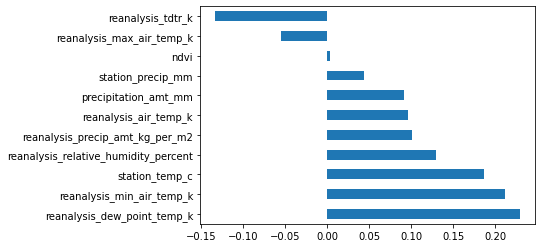

In [55]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())



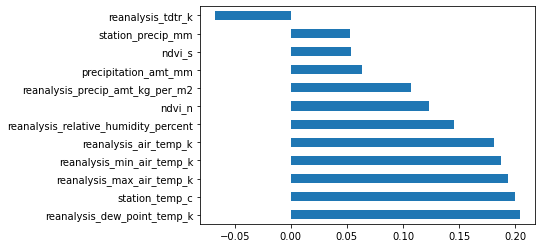

In [56]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

### A few observations

#### The wetter the better
* The correlation strengths differ for each city, but it looks like `reanalysis_specific_humidity_g_per_kg` and `reanalysis_dew_point_temp_k` are the most strongly correlated with `total_cases`. This makes sense: we know mosquitos thrive _wet_ climates, the wetter the better!

#### Hot and heavy
* As we all know, "cold and humid" is not a thing. So it's not surprising that as minimum temperatures, maximum temperatures, and average temperatures rise, the `total_cases` of dengue fever tend to rise as well.


#### A few good variables

* `reanalysis_dew_point_temp_k`
* `reanalysis_min_air_temp_k`
* `station_temp`
* `reanalysis_relative_humidity_percent`

In [57]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    df[['reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k']] -= 273.15

    df['station_temp_c'] = df[['station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c']].interpolate().mean(axis=1)

    features = ["reanalysis_dew_point_temp_k",
"reanalysis_min_air_temp_k",
"station_temp_c",
"reanalysis_relative_humidity_percent"]


    df = df[features]
    
    # fill missing values
    df.fillna(method='bfill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [58]:
sj_train, iq_train = preprocess_data('./dengue_features_train.csv',
                                    labels_path="./dengue_labels_train.csv")

In [59]:
pd.isnull(sj_train).any()

reanalysis_dew_point_temp_k             False
reanalysis_min_air_temp_k               False
station_temp_c                          False
reanalysis_relative_humidity_percent    False
total_cases                             False
dtype: bool

Since this is a timeseries model, we'll use a strict-future holdout set when we are splitting our train set and our test set. We'll keep around three quarters of the original data for training and use the rest to test. We'll do this separately for our San Juan model and for our Iquitos model.

In [60]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [61]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_dew_point_temp_k + " \
                    "reanalysis_min_air_temp_k + " \
                    "station_temp_c + " \
                    "reanalysis_relative_humidity_percent"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  21.654411764705884
best alpha =  1e-08
best score =  6.525


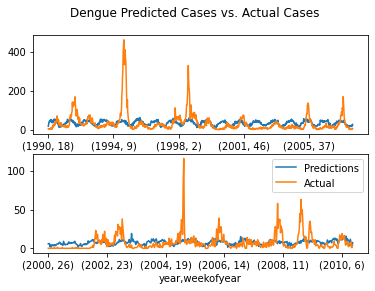

In [62]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [63]:
sj_test, iq_test = preprocess_data('./dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv("./submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("./model1.csv")

## Result

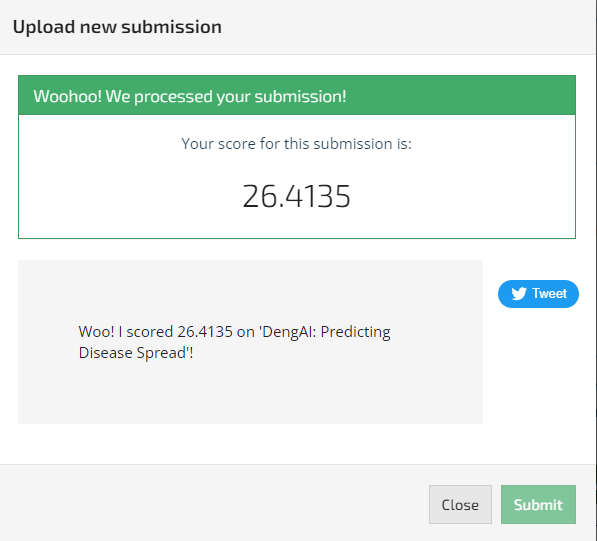
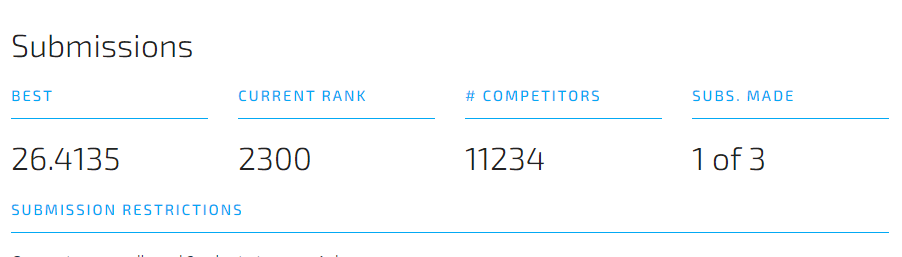

# 4 Model 2 : Linear Regression with Temporal

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

# Time Series Analysis

Taking into account from the incubation of a dengue mosquito and for the virus to develop in a human and for the symptoms to appear, we tried to include lagging in the feature datas and see the correlation between the features and response vs the lag



In [65]:
feature_sj = pd.read_csv("./myData/1_preprocessed_features_sj.csv", parse_dates=["week_start_date"],index_col="week_start_date")
feature_iq = pd.read_csv("./myData/1_preprocessed_features_iq.csv", parse_dates=["week_start_date"],index_col="week_start_date")

sj_labels = pd.read_csv("./myData/1_preprocessed_labels_sj.csv", parse_dates=["week_start_date"],index_col="week_start_date")
iq_labels = pd.read_csv("./myData/1_preprocessed_labels_iq.csv", parse_dates=["week_start_date"],index_col="week_start_date")


Moving averages are used to smooth out outliers.

Mosquito life cycle: 8-10 days. https://www.cdc.gov/dengue/entomologyecology/m_lifecycle.html

Incubation of dengue virus in human body can be upto 14 days. https://en.wikipedia.org/wiki/Dengue_fever

Incubation inside mosquito: 8-12 days. https://www.cdc.gov/dengue/epidemiology/index.html

Mosquito lives upto 4 weeks.

It looks safe to take a 5 week window.

In [66]:
feature_iq_fill = feature_iq.interpolate().drop(["weekofyear"], axis = 1).rolling(5).mean().bfill()
feature_sj_fill = feature_sj.interpolate().drop(["weekofyear"], axis = 1).rolling(5).mean().bfill()

sj_train = pd.concat([feature_sj.head(936), sj_labels[["total_cases"]]], axis = 1)
iq_train = pd.concat([feature_iq.head(936), iq_labels[["total_cases"]]], axis = 1)

print(sj_train.shape)
print(iq_train.shape)

(936, 11)
(520, 13)


In [67]:

def lagged_corr(df, skip_col, label_col, lag):
    lcorr = pd.concat([
        df.drop(skip_col, axis=1).shift(lag),
        df[[label_col]]], axis=1).corr()

    lcorr_label = lcorr[label_col].drop(label_col)

    return lcorr_label

Text(0.5, 1.0, 'Iquitos feature/label correlations')

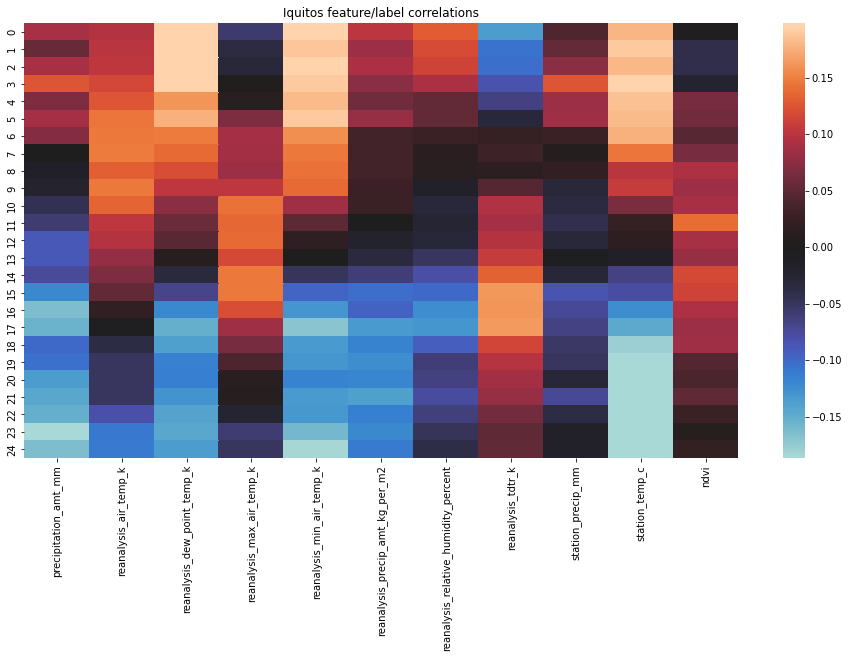

In [68]:

records_multi_lagged_corr_iq = pd.DataFrame(
    {i: lagged_corr(iq_train, ['total_cases', 'weekofyear'], 'total_cases', i) for i in range(25)}
).T

plt.figure(figsize=(16, 8))
sns.heatmap(records_multi_lagged_corr_iq, robust=True, center=0)
plt.title('Iquitos feature/label correlations')

Text(0.5, 1.0, 'San Juan feature/label correlations')

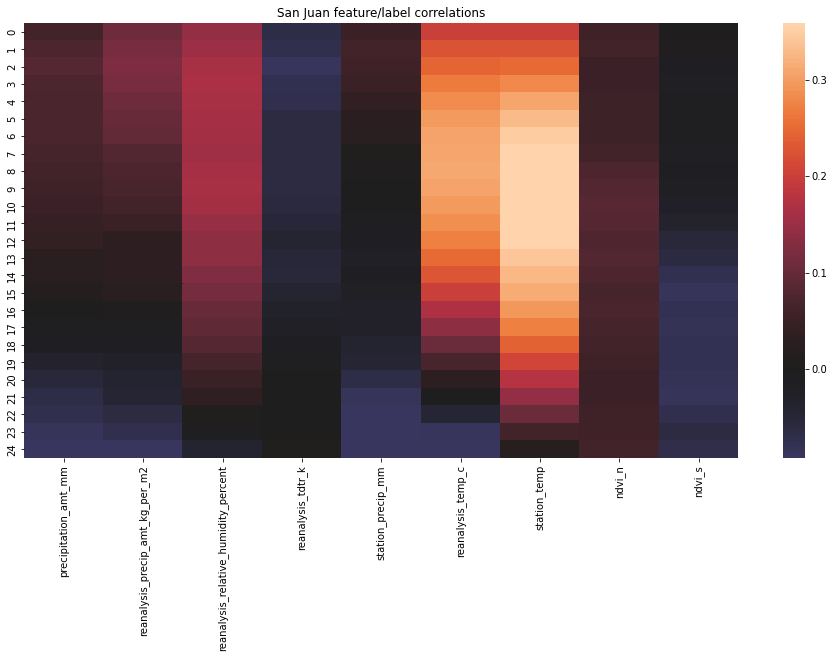

In [69]:
records_multi_lagged_corr_sj = pd.DataFrame(
    {i: lagged_corr(sj_train, ['total_cases', 'weekofyear'], 'total_cases', i) for i in range(25)}
).T

plt.figure(figsize=(16, 8))
sns.heatmap(records_multi_lagged_corr_sj, robust=True, center=0)
plt.title('San Juan feature/label correlations')

In [70]:
records_ml_corr_max_iq = pd.concat({
    'max_iq': records_multi_lagged_corr_iq.max(),
    'min_iq': records_multi_lagged_corr_iq.min(),
}, axis=1)

records_ml_corr_argmax_iq = pd.concat({
    'argmax_iq': records_multi_lagged_corr_iq.idxmax(), 
    'argmin_iq': records_multi_lagged_corr_iq.idxmin(), 
}, axis=1)

records_ml_corr_max_sj = pd.concat({
    'max_sj':records_multi_lagged_corr_sj.max(),
    'min_sj': records_multi_lagged_corr_sj.min(),
}, axis=1)

records_ml_corr_argmax_sj = pd.concat({
    'argmax_sj': records_multi_lagged_corr_sj.idxmax(),  
    'argmin_sj': records_multi_lagged_corr_sj.idxmin(), 
}, axis=1)

pd.concat([records_ml_corr_argmax_iq, records_ml_corr_argmax_sj, records_ml_corr_max_iq, 
           records_ml_corr_max_sj], axis=1, sort=True)

argmax_iq  argmin_iq  ...    max_sj    min_sj
ndvi                                       11.0        1.0  ...       NaN       NaN
ndvi_n                                      NaN        NaN  ...  0.084794  0.051869
ndvi_s                                      NaN        NaN  ...  0.004403 -0.084807
precipitation_amt_mm                        3.0       23.0  ...  0.083663 -0.105850
reanalysis_air_temp_k                       7.0       24.0  ...       NaN       NaN
reanalysis_dew_point_temp_k                 0.0       17.0  ...       NaN       NaN
reanalysis_max_air_temp_k                  14.0       23.0  ...       NaN       NaN
reanalysis_min_air_temp_k                   0.0       24.0  ...       NaN       NaN
reanalysis_precip_amt_kg_per_m2             0.0       21.0  ...  0.124202 -0.094498
reanalysis_relative_humidity_percent        0.0       17.0  ...  0.166938 -0.040944
reanalysis_tdtr_k                          17.0        0.0  ...  0.009652 -0.087836
reanalysis_temp_c                           NaN        NaN  ...  0.312662 -0.129608
station_precip_mm                           3.0       15.0  ...  0.060584 -0.095554
station_temp                                NaN        NaN  ...  0.370583  0.020902
station_temp_c                              3.0       23.0  ...       NaN       NaN

[15 rows x 8 columns]

Text(0.5, 1.0, 'Maximum lagged cross correlation iq')

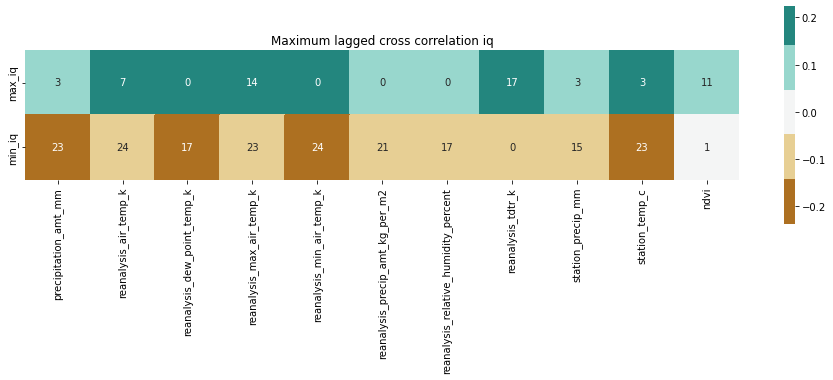

In [71]:
plt.figure(figsize=(16, 4))
sns.heatmap(records_ml_corr_max_iq.T, 
            cmap=sns.color_palette('BrBG', n_colors=5), 
            robust=True, 
            square=True, 
            center=0,
            annot=records_ml_corr_argmax_iq.T)
plt.title('Maximum lagged cross correlation iq')

Text(0.5, 1.0, 'Maximum lagged cross correlation sj')

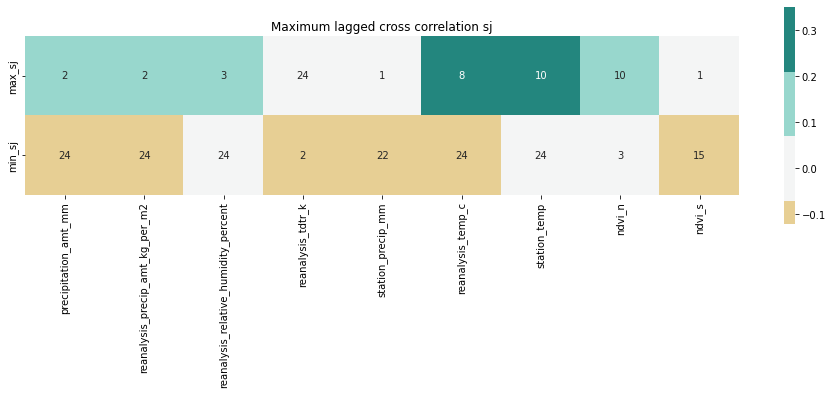

In [72]:
plt.figure(figsize=(16, 4))
sns.heatmap(records_ml_corr_max_sj.T, 
            cmap=sns.color_palette('BrBG', n_colors=5), 
            robust=True, 
            square=True, 
            center=0,
            annot=records_ml_corr_argmax_sj.T)
plt.title('Maximum lagged cross correlation sj')

In general, when the features are lagged up to 24 weeks, correlations are improved only slightly. 

It can be noted that station temperatures and reanalysis temparatures have a steady correlation with the response.

For both cities, reanalysis_precip..., reanalysis_relative_humidity_percent and station_temp have a fairly high correlation. Thought there are other features which high correlation as well, it is specific to the individual regions.

In [73]:

def feature_autoselect(corr_max, corr_argmax, city, ntake, max_lag):
    pointer_min = 0
    pointer_max = 0
    f_selected = []
    f_lags = []
    f_count = len(corr_max)
    corr_abs = corr_max.abs()
    fc_max = corr_abs['max_' + city].sort_values(ascending=False)
    fc_min = corr_abs['min_' + city].sort_values(ascending=False)
    ca_max = corr_argmax['argmax_' + city]
    ca_min = corr_argmax['argmin_' + city]
    
    while True:
        if len(f_selected) >= ntake: break
        if pointer_max >= f_count and pointer_min >= f_count: 
            break
        elif pointer_max >= f_count and pointer_min < f_count:
            if (fc_min.index.values[pointer_min] not in f_selected) \
            and (ca_min[fc_min.index[pointer_min]] <= max_lag):
                f_selected.append(fc_min.index.values[pointer_min])
                f_lags.append(ca_min[fc_min.index[pointer_min]])
            
            pointer_min += 1
        elif pointer_min >= f_count and pointer_max < f_count:
            if (fc_max.index.values[pointer_max] not in f_selected) \
            and (ca_max[fc_max.index[pointer_max]] <= max_lag):
                f_selected.append(fc_max.index.values[pointer_max])
                f_lags.append(ca_max[fc_max.index[pointer_max]])
                
            pointer_max += 1
        else:
            if fc_min[pointer_min] > fc_max[pointer_max]:
                if (fc_min.index.values[pointer_min] not in f_selected) \
                and (ca_min[fc_min.index[pointer_min]] <= max_lag):
                    f_selected.append(fc_min.index.values[pointer_min])
                    f_lags.append(ca_min[fc_min.index[pointer_min]])
                pointer_min += 1
            else:
                if (fc_max.index.values[pointer_max] not in f_selected) \
                and (ca_max[fc_max.index[pointer_max]] <= max_lag):
                    f_selected.append(fc_max.index.values[pointer_max])
                    f_lags.append(ca_max[fc_max.index[pointer_max]])
                pointer_max += 1
    
    return dict(zip(f_selected, f_lags))

In [74]:
def select_lag(source_df, select_lag):
    stl_ref_iq = pd.DataFrame(index=source_df.index)
    for k, v in select_lag.items():
        stl_ref_iq[k] = source_df[k].shift(v)

    return stl_ref_iq

In [75]:
selected_f_org_iq = feature_autoselect(corr_max=records_ml_corr_max_iq, 
                                       corr_argmax=records_ml_corr_argmax_iq, city='iq', max_lag=18, ntake=4)
selected_f_org_sj = feature_autoselect(corr_max=records_ml_corr_max_sj, 
                                       corr_argmax=records_ml_corr_argmax_sj, city='sj', max_lag=18, ntake=4)

In [76]:
selected_f_org_iq

{'reanalysis_dew_point_temp_k': 0,
 'reanalysis_min_air_temp_k': 0,
 'reanalysis_tdtr_k': 17,
 'station_temp_c': 3}

In [77]:
selected_f_org_sj

{'reanalysis_precip_amt_kg_per_m2': 2,
 'reanalysis_relative_humidity_percent': 3,
 'reanalysis_temp_c': 8,
 'station_temp': 10}

In [78]:

refined_org_iq = select_lag(feature_iq, selected_f_org_iq)
refined_org_sj = select_lag(feature_sj, selected_f_org_sj)

In [79]:
print(refined_org_iq.shape)

(520, 4)


In [80]:

features_0_train_iq = pd.concat([
    refined_org_iq, feature_iq[['weekofyear']], iq_labels[['total_cases']]
], axis=1).dropna()
features_0_train_sj = pd.concat([
    refined_org_sj, feature_sj[['weekofyear']], sj_labels[['total_cases']]
], axis=1).dropna()
# features_0_test_iq = pd.concat([feature_iq.tail(156), feature_iq.tail(156)[['weekofyear']]], axis=1)
# features_0_test_sj = pd.concat([feature_sj.tail(260), feature_sj.tail(260)[['weekofyear']]], axis=1)

In [81]:
features_0_train_iq.to_csv('./myData/2_refined_features_iq.csv')
features_0_train_sj.to_csv('./myData/2_refined_features_sj.csv')
# features_0_test_iq.to_csv('./myData/2_refined_test_iq.csv')
# features_0_test_sj.to_csv('./myData/2_refined_test_sj.csv')

## Preprocessing Test Data

In [82]:
feature_test_iq = pd.read_csv("./myData/1_preprocessed_test_iq.csv", parse_dates=["week_start_date"],index_col="week_start_date")
feature_test_sj = pd.read_csv("./myData/1_preprocessed_test_sj.csv", parse_dates=["week_start_date"],index_col="week_start_date")

refined_test_iq = select_lag(feature_test_iq, selected_f_org_iq)
refined_test_sj = select_lag(feature_test_sj, selected_f_org_sj)

features_0_test_iq = pd.concat([
    refined_test_iq, feature_test_iq[['weekofyear']]], axis=1)
features_0_test_sj = pd.concat([
    refined_test_sj, feature_test_sj[['weekofyear']]], axis=1)

features_0_test_iq.to_csv('./myData/2_refined_test_iq.csv')
features_0_test_sj.to_csv('./myData/2_refined_test_sj.csv')

In [83]:
print(features_0_test_iq.shape)

(156, 5)


Since this is a timeseries model, we'll use a strict-future holdout set when we are splitting our train set and our test set. We'll keep around three quarters of the original data for training and use the rest to test. We'll do this separately for our San Juan model and for our Iquitos model.

In [84]:
sj_train_subtrain = features_0_train_sj.head(800)
sj_train_subtest = features_0_train_sj.tail(features_0_train_sj.shape[0] - 800)

iq_train_subtrain = features_0_train_iq.head(400)
iq_train_subtest = features_0_train_iq.tail(features_0_train_iq.shape[0] - 400)
print(features_0_train_iq.columns)

Index(['reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k',
       'station_temp_c', 'reanalysis_tdtr_k', 'weekofyear', 'total_cases'],
      dtype='object')


In [85]:
class TemporalFeatureCreator(BaseEstimator, TransformerMixin):   
    def __init__(self, lookback, window_width, temporal_features):
        self.lookback = lookback
        self.window_width = window_width
        self.temporal_features = temporal_features
        
    def fit(self, X, y=None, **fit_params):        
        return self
        
    def transform(self, X, y=None, **fit_params):
        self.X = X.copy()
        periodic_features = ['periodic_' + f for f in self.temporal_features]
        mean_window_features = ['mean_' + f for f in self.temporal_features]
        max_window_features = ['max_' + f for f in self.temporal_features]
        min_window_features = ['min_' + f for f in self.temporal_features]

        self.X[periodic_features] = self.X[self.temporal_features].shift(self.lookback )
        self.X[mean_window_features] = self.X[self.temporal_features].shift(self.window_width - 1).rolling(window=self.window_width).mean()
        self.X[max_window_features] = self.X[self.temporal_features].shift(self.window_width - 1).rolling(window=self.window_width).max()
        self.X[min_window_features] = self.X[self.temporal_features].shift(self.window_width - 1).rolling(window=self.window_width).min()
        self.X.fillna(self.X.median(), inplace=True)
        return self.X
print(features_0_train_sj.columns)
ftr_crtr = TemporalFeatureCreator(10,10,features_0_train_sj.columns)
X_train = ftr_crtr.fit_transform(sj_train_subtrain,sj_labels)
X_train.describe()

Index(['station_temp', 'reanalysis_temp_c',
       'reanalysis_relative_humidity_percent',
       'reanalysis_precip_amt_kg_per_m2', 'weekofyear', 'total_cases'],
      dtype='object')


station_temp  reanalysis_temp_c  ...  min_weekofyear  min_total_cases
count    800.000000         800.000000  ...      800.000000       800.000000
mean      27.077122          25.067912  ...       18.996250        19.228750
std        1.437399           1.276499  ...       13.771103        27.805987
min       22.980952          21.252857  ...        1.000000         0.000000
25%       25.958333          24.008304  ...        5.000000         4.000000
50%       27.335714          25.354286  ...       19.000000        12.000000
75%       28.259524          26.127321  ...       31.000000        23.000000
max       30.061905          27.898929  ...       44.000000       302.000000

[8 rows x 30 columns]

In [86]:
from statsmodels.tools import eval_measures
import statsmodels.api as sm
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # ftr_crtr = TemporalFeatureCreator(10,10,train.columns)
    # train = ftr_crtr.fit_transform(train,train.total_cases)
    # test = ftr_crtr.fit_transform(test,test.total_cases)

    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " + " + ".join(filter(lambda s: s != 'total_cases', list(train.columns)))
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  0.0001
best score =  21.796296296296298
best alpha =  1e-08
best score =  7.073684210526316


## Submission

In [87]:
feature_test_sj = pd.read_csv("./myData/2_refined_test_sj.csv", 
                                       parse_dates=['week_start_date'], 
                                       index_col='week_start_date')
feature_test_iq = pd.read_csv("./myData/2_refined_test_iq.csv", 
                                       parse_dates=['week_start_date'], 
                                       index_col='week_start_date')


In [88]:
sj_predictions = sj_best_model.predict(feature_test_sj).rolling(7, center=True).mean().bfill().ffill().astype(int)
iq_predictions = iq_best_model.predict(feature_test_iq).rolling(7, center=True).mean().bfill().ffill().astype(int)

In [89]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("./Approach2.csv")
submission

total_cases
city year weekofyear             
sj   2008 18                   36
          19                   36
          20                   36
          21                   36
          22                   36
...                           ...
iq   2013 22                    6
          23                    6
          24                    6
          25                    6
          26                    6

[416 rows x 1 columns]

## Result

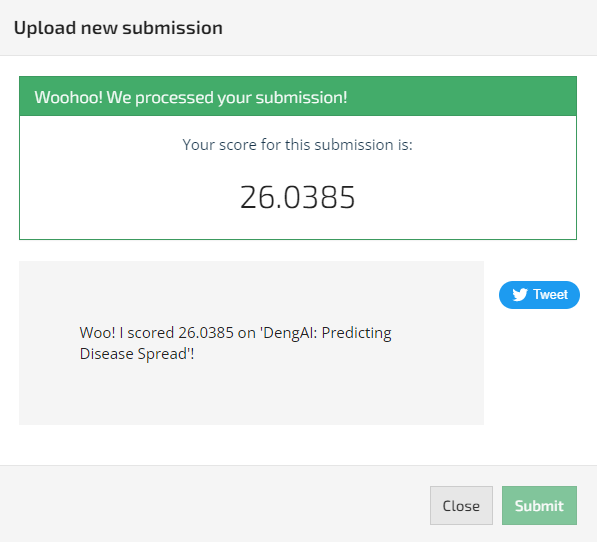
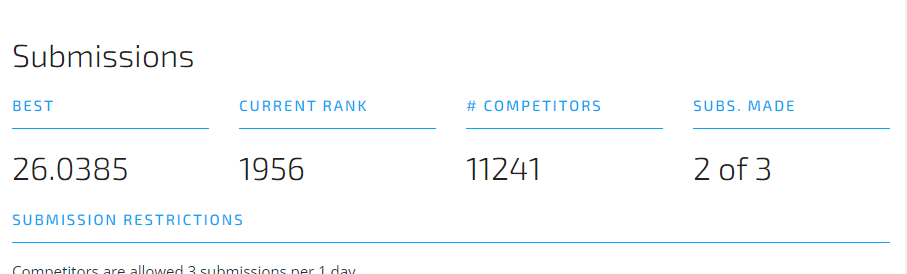

# 5 Model 3: Classification + Regression

For classification, we will start from scratch.

In [90]:
features = pd.read_csv('./dengue_features_train.csv',
                             index_col=[0,1,2])

labels = pd.read_csv('./dengue_labels_train.csv',
                           index_col=[0,1,2])

In [91]:
features.drop(['week_start_date'], axis=1, inplace=True)

In [92]:
# Seperate data for San Juan
sj_features = features.loc['sj']
sj_labels = labels.loc['sj']

# Separate data for Iquitos
iq_features = features.loc['iq']
iq_labels = labels.loc['iq']

## Splitting into training and validation data

In [93]:
iq_features = iq_features.sort_index()
iq_labels = iq_labels.sort_index()

sj_features = sj_features.sort_index()
sj_labels = sj_labels.sort_index()

iq_test_size = int(iq_features.shape[0]*0.2)
sj_test_size = int(sj_features.shape[0]*0.2)


print("iq test size:",iq_test_size)
print("sj test size:",sj_test_size)

iq test size: 104
sj test size: 187


In [94]:
iq_train_features = iq_features[:-iq_test_size]
iq_train_labels = iq_labels[:-iq_test_size]

sj_train_features = sj_features[:-sj_test_size]
sj_train_labels = sj_labels[:-sj_test_size]

iq_test_features = iq_features[-iq_test_size:]
iq_test_labels = iq_labels[-iq_test_size:]                                                           
                                                                
sj_test_features = sj_features[-sj_test_size:]
sj_test_labels = sj_labels[-sj_test_size:]  

print("iq train ",(iq_train_features.shape,iq_train_labels.shape),"\nsj train",(sj_train_features.shape,sj_train_labels.shape))
print("iq test",(iq_test_features.shape,iq_test_labels.shape),"\nsj test",(sj_test_features.shape,sj_test_labels.shape))

iq train  ((416, 20), (416, 1)) 
sj train ((749, 20), (749, 1))
iq test ((104, 20), (104, 1)) 
sj test ((187, 20), (187, 1))


##Imputators

First we will have a custom imputor which will return a dataframe to have columns to create new features.

In [95]:
class CustomerImputors( BaseEstimator, TransformerMixin):   
    def __init__(self, imputor):
        self.imputor = imputor
        pass
    
    def fit(self, X, y=None, **fit_params):
        return self
        
    def transform(self, X, y=None, **fit_params):
        
        self.X = X.copy()
        self.X = pd.DataFrame(self.imputor.fit_transform(self.X), index=self.X.index, columns=self.X.columns)

        return self.X

In [96]:

numeric_imp = SimpleImputer(strategy='median')
cat_bin_imp = SimpleImputer(strategy='most_frequent')
KNN_imputer = KNNImputer(n_neighbors=10)

## Feature Creator


Build a feature creator to get the mean of the ndvi_ne, ndvi_nw, ndvi_se, ndvi_sw as the city is evaluated as a whole without differentiate the case

In [97]:
class FeatureCreator( BaseEstimator, TransformerMixin ):   
    def __init__(self):
        pass
        
    def fit(self, X, y=None, **fit_params):
            
        return self
        
    def transform(self, X, y=None, **fit_params):
        self.X = X.copy()

        self.X['ndvi_total'] = self.X.ndvi_ne + self.X.ndvi_nw + self.X.ndvi_se + self.X.ndvi_sw
        self.X.drop(columns=['ndvi_ne','ndvi_nw','ndvi_se','ndvi_sw'], inplace= True)
        return self.X

## Building Pipeline

Here we will run GRIDSEARCH in order to find the best hyperparameter. Followed by finding the best features to evaluate on

In [98]:
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, RobustScaler, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression, Ridge,Lasso, ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

est_A1 = Pipeline(steps=[
    ('imp', cat_bin_imp),
    # ('ftr_crtr', FeatureCreator()),
    ('ftr_slctr', SelectKBest(k="all")),
    ('polyftr', PolynomialFeatures(3)),
    ('linreg',LinearRegression())
])
est_A1_params = {
    # "imp__imputor": [numeric_imp,KNN_imputer],
    "ftr_slctr__k": [ "all",2,5,8],
    "polyftr__degree": [4,2,3],
    # "linreg": [LinearRegression(), XGBRegressor(),AdaBoostRegressor(), SGDRegressor()]
}

est_A1_gscv = GridSearchCV(est_A1, param_grid=est_A1_params, cv = 5,verbose = 1,
                        scoring = "neg_mean_squared_error",error_score="raise")

reg_iq = est_A1_gscv.fit(iq_train_features, iq_train_labels)
reg_sj = est_A1_gscv.fit(sj_train_features, sj_train_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   12.0s finished


In [99]:

cols = reg_sj.best_estimator_['ftr_slctr'].get_support(indices=True)
features_k_best = iq_train_features.iloc[:,cols]
features_k_best.columns

Index(['reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent'], dtype='object')

In [100]:
class TemporalFeatureCreator(BaseEstimator, TransformerMixin):   
    def __init__(self, lookback, window_width, temporal_features):
        self.lookback = lookback
        self.window_width = window_width
        self.temporal_features = temporal_features
        
    def fit(self, X, y=None, **fit_params):        
        return self
        
    def transform(self, X, y=None, **fit_params):
        self.X = X.copy()
        periodic_features = ['periodic_' + f for f in self.temporal_features]
        mean_window_features = ['mean_' + f for f in self.temporal_features]
        max_window_features = ['max_' + f for f in self.temporal_features]
        min_window_features = ['min_' + f for f in self.temporal_features]

        self.X[periodic_features] = self.X[self.temporal_features].shift(self.lookback )
        self.X[mean_window_features] = self.X[self.temporal_features].shift(self.window_width - 1).rolling(window=self.window_width).mean()
        self.X[max_window_features] = self.X[self.temporal_features].shift(self.window_width - 1).rolling(window=self.window_width).max()
        self.X[min_window_features] = self.X[self.temporal_features].shift(self.window_width - 1).rolling(window=self.window_width).min()
        self.X.fillna(self.X.median(), inplace=True)
        return self.X

## Model

In [101]:
iq_labels.describe(),iq_labels.quantile(q=[0.25,0.5,0.75,1])['total_cases'][0.25]

(       total_cases
 count   520.000000
 mean      7.565385
 std      10.765478
 min       0.000000
 25%       1.000000
 50%       5.000000
 75%       9.000000
 max     116.000000, 1.0)

The goal is to categorise each region such that there are more of less equal number of data to train. Hence using the result above, We decided to divide it into 4 ranges - 0 to 25, 25-50,50-75,75-100%

Under 25% total case signifies that it is safe to the general public
From 25% to median, that means it is normal since the case number is in the middle range.
Above the median would be risky to the public, whereas 75% to max will be dangerous.

In [102]:
class ClassLabelCreator( BaseEstimator, TransformerMixin ):   
    def __init__(self):
        self.risk_level ={
            'safe':(0,0.25),
            'normal':(0.25,0.5),
            'risky':(0.5,0.75),
            'dangerous':(0.75,1.0)
        } 
        pass
        
    def fit(self, y, **fit_params):
        self.percentiles = y.quantile(q=[0,0.25,0.5,0.75,1.0])['total_cases']
        self.percentiles[1.0] = self.percentiles[1.0] +1
        return self
        
    def transform(self, y, **fit_params):
        self.y = y.copy()
        for lvl, item in self.risk_level.items():
            self.y.loc[(self.y['total_cases'] >= self.percentiles[item[0]]) & (self.y['total_cases'] < self.percentiles[item[1]]),"risk_level"] = str(lvl)
        self.y.drop(columns=['total_cases'], inplace=True)
        
        return self.y
clc = ClassLabelCreator()

In [103]:

sj_train_clss_labels = clc.fit_transform(sj_train_labels)
iq_train_clss_labels = clc.fit_transform(iq_train_labels)
sj_test_clss_labels = clc.fit_transform(sj_test_labels)
iq_test_clss_labels = clc.fit_transform(iq_test_labels)
# sj_train_clss_labels[(sj_train_clss_labels["risk_level"]. in ['safe', 'normal', 'risky', 'dangerous'])]

# sj_train_clss_labels["risk_level"].value_counts().plot(kind='bar')

## Pipeline for classification

In [104]:

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

est_A3 = Pipeline(steps=[
    ('imp', CustomerImputors(KNN_imputer)),
    ('tmprl_ftr_crtr', TemporalFeatureCreator(lookback=4,window_width=9, temporal_features=list(features_k_best.columns))),
    ('ftr_slctr', SelectKBest(k="all")),
    ('clsr',RandomForestClassifier())
])

In [105]:

est_A3_params = {
    "ftr_slctr__k": [2,4,8],
    "clsr__n_estimators" : [50,100,200],
    # "clsr__learning_rate" : [0.01,0.1],
    "clsr__max_depth" : [3,5]
}

xgb_grid = GridSearchCV(est_A3,est_A3_params,cv = 5,verbose = 1,
                        scoring = "roc_auc_ovr", error_score="raise")

xgb_grid_sj = xgb_grid.fit(sj_train_features,sj_train_clss_labels["risk_level"])
xgb_grid_iq = xgb_grid.fit(iq_train_features,iq_train_clss_labels["risk_level"])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   32.5s finished


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   25.6s finished


In [106]:
sj_train_features = CustomerImputors(KNN_imputer).fit_transform(sj_train_features)
iq_train_features = CustomerImputors(KNN_imputer).fit_transform(iq_train_features)
sj_test_features = CustomerImputors(KNN_imputer).fit_transform(sj_test_features)
iq_test_features = CustomerImputors(KNN_imputer).fit_transform(iq_test_features)

In [107]:
xgb_grid_sj.best_params_,xgb_grid_iq.best_params_

({'clsr__max_depth': 3, 'clsr__n_estimators': 50, 'ftr_slctr__k': 4},
 {'clsr__max_depth': 3, 'clsr__n_estimators': 50, 'ftr_slctr__k': 4})

In [108]:
xgb_grid_sj.best_score_,xgb_grid_iq.best_score_

(0.6457096216524836, 0.6457096216524836)

In [109]:
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix

iq_pred_clss_labels= xgb_grid_iq.best_estimator_.predict(iq_test_features)
sj_pred_clss_labels= xgb_grid_sj.best_estimator_.predict(sj_test_features)
print(iq_pred_clss_labels.shape, sj_pred_clss_labels.shape)

roc_auc_iq = np.sum(multilabel_confusion_matrix(iq_test_clss_labels, iq_pred_clss_labels), axis = 0)
print("iq test confusion_matrix:\n",roc_auc_iq)

roc_auc_sj = np.sum(multilabel_confusion_matrix(sj_test_clss_labels, sj_pred_clss_labels), axis = 0)
print("sj test confusion_matrix:\n",roc_auc_iq)

(104,) (187,)
iq test confusion_matrix:
 [[231  81]
 [ 81  23]]
sj test confusion_matrix:
 [[231  81]
 [ 81  23]]


The confusion matrix proves that most class label are correctly represented

Next i will join the result labels of the classification so that further down I can train the regression models for each different class label.

In [110]:
sj_train_features_with_clss = sj_train_features.join(sj_train_clss_labels)
iq_train_features_with_clss = iq_train_features.join(iq_train_clss_labels)

sj_test_features_with_clss = sj_test_features.join(sj_test_clss_labels)
iq_test_features_with_clss = iq_test_features.join(iq_test_clss_labels)

print("sj classfication train features: ", sj_train_features_with_clss.shape, "\niq classfication train features: ",  iq_train_features_with_clss.shape)
print("sj classfication test features: ", sj_test_features_with_clss.shape, "\niq classfication test features: ", iq_test_features_with_clss.shape)

sj classfication train features:  (749, 21) 
iq classfication train features:  (416, 21)
sj classfication test features:  (187, 21) 
iq classfication test features:  (104, 21)


Next, we will be using Neural Network as our regression model to test each classification region

Specifically, we will be using skorch for this part.

In [112]:
!pip install skorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable 

from torch import optim

from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring
from skorch.utils import to_tensor
from skorch.helper import DataFrameTransformer
from sklearn.pipeline import Pipeline

     |████████████████████████████████| 155 kB 5.5 MB/s 


First we will build the LSTM Neral Net and run a GridSearch to find the best hyperparameter

In [113]:
class LSTM_NeuralNet(nn.Module):
    def __init__(self, layers_num=3, input_dim=21, hidden_dim=10,bidirectional=True, dropout=0.1):
        super(LSTM_NeuralNet, self).__init__()
        # self.max_lookback = max_lookback
        self.layers_num = layers_num
        self.hidden_dim = hidden_dim
        self.LSTM_layer = nn.LSTM(input_dim, hidden_dim, layers_num, dropout=dropout, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_dim, 1) #fully connected 1

    def forward(self, x):        
        h_0 = Variable(torch.zeros(self.layers_num, x.size(0), self.hidden_dim).type('torch.FloatTensor')) #hidden state
        c_0 = Variable(torch.zeros(self.layers_num, x.size(0), self.hidden_dim).type('torch.FloatTensor'))#internal state
        x = torch.reshape(x,(x.shape[0], 1, x.shape[1])).type('torch.FloatTensor')

        output, (hn, cn) = self.LSTM_layer(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = output.view(-1, self.hidden_dim)
        out = self.fc_1(out)
        
        return out
        
# The Neural Net is initialized with fixed hyperparameters
nnc = NeuralNetRegressor(
    LSTM_NeuralNet, 
    max_epochs=10, 
    lr=0.001, 
    batch_size=32,
    verbose = 0
)
params = {
	'lr': [0.01, 0.1],
    'module__layers_num': [2, 3],
	'module__dropout': [0, 0.1, 0.2],
	'optimizer': [optim.SGD, optim.RMSprop]}

gs_reg_dnn = GridSearchCV(nnc, params, cv=5, scoring='neg_mean_squared_error', error_score="raise")

Next, we create a method to encode the class labels by applying One Hot Encoder on the features

In [114]:
def transform_class_label(features_with_clss,labels, lvl):
    data = features_with_clss.join(labels)
    data_with_clss = data[data['risk_level'] == lvl]
    features = data_with_clss.drop(['total_cases'], axis=1)
    labels = data_with_clss[['total_cases']]
    
    return OrdinalEncoder().fit_transform(features), labels.to_numpy(dtype="float32")

## Training Regression

Next, we will fit and train our regression model

In [115]:
risk_levels=['safe', 'normal', 'risky', 'dangerous']
essembled_regs= {}
for lvl in risk_levels:
    print("Fit for ", lvl)
    
    print('Training sj_reg_dnn_' + lvl + " module")
    sj_features, sj_labels = transform_class_label(sj_train_features_with_clss,sj_train_labels, lvl)
    essembled_regs['sj_reg_dnn_' + lvl] = gs_reg_dnn.fit(sj_features, sj_labels)
    
    print('Training iq_reg_dnn_' + lvl + " module")
    iq_features, iq_labels = transform_class_label(iq_train_features_with_clss,iq_train_labels, lvl)
    essembled_regs['iq_reg_dnn_' + lvl] = gs_reg_dnn.fit(iq_features, iq_labels)

Fit for  safe
Training sj_reg_dnn_safe module
Training iq_reg_dnn_safe module
Fit for  normal
Training sj_reg_dnn_normal module
Training iq_reg_dnn_normal module
Fit for  risky
Training sj_reg_dnn_risky module
Training iq_reg_dnn_risky module
Fit for  dangerous
Training sj_reg_dnn_dangerous module
Training iq_reg_dnn_dangerous module


## Predicting

In [116]:
pred_result = list()
for lvl in risk_levels:
    for key,dnn_reg in essembled_regs.items():
        if lvl in key:
            if "sj" in key:
                test_data = sj_test_features_with_clss[sj_test_features_with_clss['risk_level']==lvl]
                # print(key,'\n',dnn_reg.best_estimator_)
            else:
                test_data = iq_test_features_with_clss[iq_test_features_with_clss['risk_level']==lvl]
                # print(key,'\n',dnn_reg.best_estimator_)
            print("Predicting with",key, 'for',lvl)
            test_data['predict'] = dnn_reg.best_estimator_.predict(OrdinalEncoder().fit_transform(test_data))
            print(test_data[['predict']].shape)
            pred_result.append(test_data['predict'].round().clip(lower=0).astype(int))
            print()
pred_lables = pd.concat(pred_result)
pred_lables

Predicting with sj_reg_dnn_safe for safe
(44, 1)

Predicting with iq_reg_dnn_safe for safe
(17, 1)

Predicting with sj_reg_dnn_normal for normal
(43, 1)

Predicting with iq_reg_dnn_normal for normal
(26, 1)

Predicting with sj_reg_dnn_risky for risky
(53, 1)

Predicting with iq_reg_dnn_risky for risky
(34, 1)

Predicting with sj_reg_dnn_dangerous for dangerous
(47, 1)

Predicting with iq_reg_dnn_dangerous for dangerous
(27, 1)



year  weekofyear
2004  46            16
      49            15
2005  9             16
      10            16
      12            16
                    ..
2010  7             16
      8             16
      9             16
      10            16
      11            16
Name: predict, Length: 291, dtype: int64

In [117]:
import itertools
pred_result_list = list(itertools.chain.from_iterable(pred_result[:2]))

In [118]:
print(pred_result_list)

[16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 15, 16, 15, 15, 15, 15, 16, 15, 15, 16, 14, 15, 16, 16, 16, 16, 16, 15, 15, 16, 16, 16, 16, 16, 15, 15, 16]


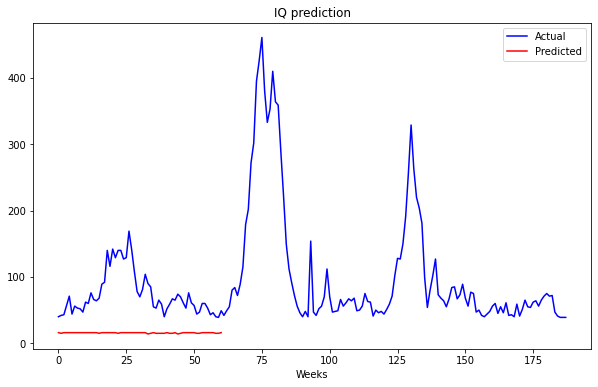

In [119]:
plt.figure(figsize=(10,6))
plt.plot(sj_labels, color='blue', label='Actual')
plt.plot(pred_result_list , color='red', label='Predicted')
plt.title('IQ prediction')
plt.xlabel('Weeks')
plt.legend()
plt.show()

As seen, the predicted vastly differs from the actual.

This model might not be a good representative of the classficiation model


A submission was not made for this model

# 6 Model 4 : Neural Network Model

# 6.1 Using Pytorch

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import torch

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

!pip install ax-platform
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting

     |████████████████████████████████| 866 kB 5.3 MB/s 
     |████████████████████████████████| 486 kB 46.8 MB/s 
     |████████████████████████████████| 503 kB 50.0 MB/s 


## Preparing the data 

In [121]:
features=pd.read_csv('dengue_features_train.csv')
labels=pd.read_csv('dengue_labels_train.csv')

In [122]:
features_train_raw_sj = features[features.city == "sj"].drop("city",1)
features_train_raw_iq = features[features.city == "iq"].drop("city",1)
labels_test_raw_sj = labels[labels.city == "sj"].drop("city",1)
labels_test_raw_iq = labels[labels.city == "iq"].drop("city",1)

In [123]:
features_train_raw_sj = features_train_raw_sj.drop( "week_start_date", axis = 1)
features_train_raw_iq = features_train_raw_iq.drop( "week_start_date", axis = 1)



In [124]:
print(features_train_raw_sj.shape)
print(features_train_raw_iq.shape)
print(labels_test_raw_sj.shape)
print(labels_test_raw_iq.shape)

(936, 22)
(520, 22)
(936, 3)
(520, 3)


In [125]:
print(labels_test_raw_sj.columns)

Index(['year', 'weekofyear', 'total_cases'], dtype='object')


For NN, we will just impute the missing values  simply by ffill

In [126]:
feature_iq_fill = features_train_raw_iq.fillna(method='ffill')
feature_sj_fill = features_train_raw_sj.fillna(method='ffill')

print(feature_sj_fill.shape)

(936, 22)


checking if there are still any null present which shouldnt be

In [127]:
pd.isnull(feature_iq_fill).any()

year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_preci

In [128]:
pd.isnull(feature_sj_fill).any()

year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_temp_c                       False
station_preci

Initially, normalising of the data was not done which resulted int predictions being majority 0 or 1 which was weird.

Hence, after trial and error, normalising was conducted to allow for easier backpropagation. 

In [129]:
feature_iq_fill=(feature_iq_fill-feature_iq_fill.mean())/feature_iq_fill.std()
feature_sj_fill=(feature_sj_fill-feature_sj_fill.mean())/feature_sj_fill.std()

Splitting the data to 80-20

In [147]:
iq_x_train, iq_x_test = np.split(feature_iq_fill, [int((4*feature_iq_fill.shape[0])/5)])
iq_y_train, iq_y_test = np.split(labels_test_raw_iq, [int((4*labels_test_raw_iq.shape[0])/5)])
sj_x_train, sj_x_test = np.split(feature_sj_fill, [int((4*feature_sj_fill.shape[0])/5)])
sj_y_train, sj_y_test = np.split(labels_test_raw_sj, [int((4*labels_test_raw_sj.shape[0])/5)])

## Neural Network

As seen from the shape above, we ahve 22 columns,
therefore we will have 22 input neurons.

In our network, we shall input 1 hidden layer and since our output must be a positive number, our activation function is relu.

In [131]:
class Deng(nn.Module):
    def __init__(self, hidden):
        super().__init__()
        self.linear1 = nn.Linear(22, hidden)
        self.linear2 = nn.Linear(hidden,1)
        self.act=nn.ReLU()

    def forward(self, xb):
        return self.linear2(self.act(self.linear1(xb.float())))

Since we will be iterative over batches, we will use DataLoader.

Here wie will first convert the data to Tensors, and then wrap it with a Dataset followed by DataLoader.

In [149]:
bs=10
# iq_training
iq_x_train_tensor=torch.from_numpy(iq_x_train.values)
iq_y_train_tensor=torch.from_numpy(iq_y_train[['total_cases']].values)
print(iq_x_train_tensor.shape)
print(iq_y_train_tensor.shape)
iq_train=TensorDataset(iq_x_train_tensor, iq_y_train_tensor)
iq_train_dl = DataLoader(iq_train, batch_size=bs, shuffle=True)
print(iq_train_dl)

# iq validation
iq_x_test_tensor=torch.from_numpy(iq_x_test.values)
iq_y_test_tensor=torch.from_numpy(iq_y_test[['total_cases']].values)
iq_test=TensorDataset(iq_x_test_tensor, iq_y_test_tensor)
iq_test_dl = DataLoader(iq_test, batch_size=bs, shuffle=True)


# sj training
sj_x_train_tensor=torch.from_numpy(sj_x_train.values)
sj_y_train_tensor=torch.from_numpy(sj_y_train[['total_cases']].values)
sj_train=TensorDataset(sj_x_train_tensor, sj_y_train_tensor)
sj_train_dl = DataLoader(sj_train, batch_size=bs, shuffle=True)

# sj validation
sj_x_test_tensor=torch.from_numpy(sj_x_test.values)
sj_y_test_tensor=torch.from_numpy(sj_y_test[['total_cases']].values)
sj_test=TensorDataset(sj_x_test_tensor, sj_y_test_tensor)
sj_test_dl = DataLoader(sj_test, batch_size=bs, shuffle=True)

torch.Size([416, 22])
torch.Size([416, 1])


As per the documentation, (https://pytorch.org/docs/stable/nn.html#loss-functions), since we are dealing with mean absolute error, our loss function is as such:

In [150]:
loss_func=nn.L1Loss()

Next we will create the train and evaluate method as per Tutorial 10 solutions.

In [151]:
## helper train/fit function

def train(net, parameterization, trainloader):
    optimizer = optim.SGD(net.parameters(), lr=parameterization["lr"], momentum=parameterization["momentum"])
    
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        
    return net

            
## helper function to evaluate the accuracy for the tested model
def evaluate(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        total_loss = sum(loss_func(net(xb), yb).item() for xb, yb in testloader)
        avg_loss=(total_loss)/len(testloader)
        
        return avg_loss



Since we will be testing them separately, there will be 2 different train_eval method.

This method is used to optimise. The function takes in a parameterization (set of parameter values), computes the desired metric, and returns a dictionary of metric name to a tuple with the mean and standard error. Here, we just compute the loss and return the value.

In [152]:
def iq_train_eval(parameterization):
    model = Deng(parameterization['hidden'])
    model = train(model, parameterization, iq_train_dl)
    return evaluate(model, iq_test_dl)

def sj_train_eval(parameterization):
    model = Deng(parameterization['hidden'])
    model = train(model, parameterization, sj_train_dl)
    return evaluate(model, sj_test_dl)

## Optimization

Now we are ready to run the optimization loop.

For this model, we will tune to find the best 


1.   Number of hidden layer
2.   Learning Rate
3. Momentum



Since SJ have a larger dataset, we shall run it 10 times.

In [153]:
#SJ

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "hidden", "type": "choice", "values": [3,4,5,10,13,15,17,20]},       
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
    ],
    evaluation_function=sj_train_eval,
    minimize = True, 
    objective_name='loss',
    total_trials=10
)

[INFO 11-10 05:18:56] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter hidden. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[WARNING 11-10 05:18:56] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "hidden". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[INFO 11-10 05:18:56] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-10 05:18:56] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' o

As IQ have a smaller dataset, we will run it for 15 trials

In [154]:
#IQ

iq_best_parameters, iq_values, iq_experiment, iq_model = optimize(
    parameters=[
        {"name": "hidden", "type": "choice", "values": [2,3,4,5,10,15,20]},       
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
    ],
    evaluation_function=iq_train_eval,
    minimize = False, #this is also default
    objective_name='loss',
    total_trials=15
)

[INFO 11-10 05:19:55] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter hidden. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[WARNING 11-10 05:19:55] ax.core.parameter: `sort_values` is not specified for `ChoiceParameter` "hidden". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.
[INFO 11-10 05:19:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-10 05:19:55] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' o

After optimizing, we will find out the best hyperparameters

In [155]:
print("iq best param: ", iq_best_parameters)
print("sj best param: ", best_parameters)
print("iq values: ", iq_values)
print("sj values: ", values)

iq best param:  {'hidden': 5, 'lr': 1e-06, 'momentum': 0.32773336959326}
sj best param:  {'hidden': 10, 'lr': 0.026813520630258485, 'momentum': 0.0}
iq values:  ({'loss': 9.894792556762695}, {'loss': {'loss': nan}})
sj values:  ({'loss': 16.52306097432187}, {'loss': {'loss': nan}})


## Plotting

Visualising the model performance of the trials as the trials in ax progressed

In [156]:
objectives = np.array([[trial.objective_mean for trial in iq_experiment.trials.values()]])
objectives
best_objective_plot = optimization_trace_single_method(
    y=objectives,
    title="IQ Model performance vs. trial#",
    ylabel="LOSS",
)
render(best_objective_plot)

In [157]:
objectives = np.array([[trial.objective_mean for trial in experiment.trials.values()]])
objectives
best_objective_plot = optimization_trace_single_method(
    y=objectives,
    title="SJ Model performance vs. trial#",
    ylabel="LOSS",
)
render(best_objective_plot)

## Validation of model

Now we will apply the hyperparameters we found from tuning and validate the model with our validation sets.

In [158]:
from torch import optim
def get_model():
    model = Deng(iq_best_parameters["hidden"])
    return model, optim.SGD(model.parameters(), lr=iq_best_parameters["lr"], momentum=iq_best_parameters["momentum"])

model, opt = get_model()

def fit():
    for epoch in range(15):
        model.train()
        for xb, yb in iq_train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():

            valid_loss = sum(loss_func(model(xb), yb) for xb, yb in iq_test_dl)
            print(epoch, valid_loss / len(iq_test_dl))
        

fit()


0 tensor(9.5523)
1 tensor(9.4157)
2 tensor(9.1171)
3 tensor(9.1076)
4 tensor(8.9163)
5 tensor(9.0046)
6 tensor(9.2363)
7 tensor(9.0377)
8 tensor(8.9298)
9 tensor(8.8601)
10 tensor(9.2562)
11 tensor(9.1111)
12 tensor(9.0953)
13 tensor(8.8699)
14 tensor(9.0379)


In [159]:
from torch import optim
def get_model():
    sj_model = Deng(best_parameters["hidden"])
    return sj_model, optim.SGD(sj_model.parameters(), lr=best_parameters["lr"], momentum=best_parameters["momentum"])

sj_model, opt = get_model()

def sj_fit():
    for epoch in range(15):
        sj_model.train()
        for xb, yb in sj_train_dl:
            pred = sj_model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

        sj_model.eval()
        with torch.no_grad():

            valid_loss = sum(loss_func(sj_model(xb), yb) for xb, yb in sj_test_dl)
            print(epoch, valid_loss / len(sj_test_dl))
        

sj_fit()

0 tensor(17.4844)
1 tensor(16.5784)
2 tensor(16.0984)
3 tensor(16.5695)
4 tensor(16.4659)
5 tensor(17.2905)
6 tensor(15.9079)
7 tensor(15.9467)
8 tensor(15.6832)
9 tensor(15.9483)
10 tensor(16.0144)
11 tensor(16.3924)
12 tensor(16.2407)
13 tensor(17.0519)
14 tensor(16.3987)


## Submission

In [160]:
test = pd.read_csv("dengue_features_test.csv")

testsj = test[test.city == "sj"].drop("city",1)
testiq = test[test.city == "iq"].drop("city",1)

testsj = testsj.drop( "week_start_date", axis = 1)
testiq = testiq.drop( "week_start_date", axis = 1)

testiq = testiq.fillna(method='ffill')
testsj = testsj.fillna(method='ffill')

testiq=(testiq-testiq.mean())/testiq.std()
testsj=(testsj-testsj.mean())/testsj.std()

In [161]:
iq_preds=[]
for row in testiq.values:
    pred = model(torch.from_numpy(row)).detach().numpy()[0]
    iq_preds.append(0 if pred<0 else int(pred.round()))

In [162]:
sj_preds=[]
for row in testsj.values:
    pred = sj_model(torch.from_numpy(row)).detach().numpy()[0]
    sj_preds.append(0 if pred<0 else int(pred.round()))

In [163]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_preds, iq_preds])
submission.to_csv("pytorch.csv")

## Result

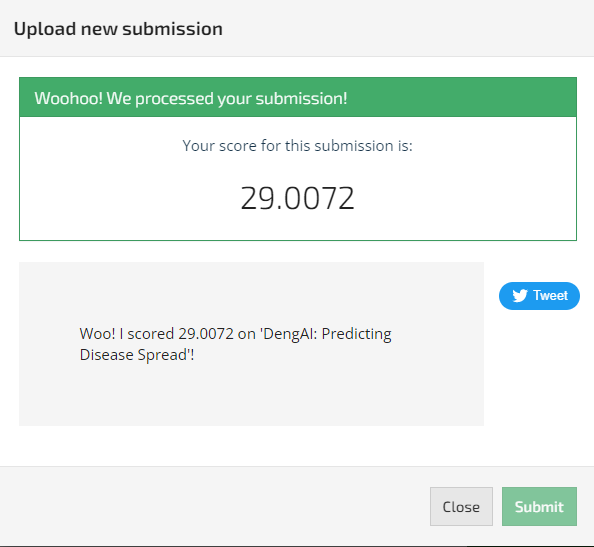

# 6.2 Using Keras 

LSTM are a special type of RNN that can handle long-term dependencies (rownlee, J., 2020. How to Use XGBoost for Time Series Forecasting, s.l.: Machine Learning Mastery.). For this reason, they are among the most widely used types of neural networks to date.

So we will be trying out this model.

In [164]:
# sj_train = pd.read_csv("./myData/1_preprocessed_features_sj.csv", parse_dates=["week_start_date"])[:936]
# iq_train = pd.read_csv("./myData/1_preprocessed_features_iq.csv", parse_dates=["week_start_date"])[:520]

# sj_labels = pd.read_csv("./myData/1_preprocessed_labels_sj.csv", parse_dates=["week_start_date"])
# iq_labels = pd.read_csv("./myData/1_preprocessed_labels_iq.csv", parse_dates=["week_start_date"])

# sj_test = pd.read_csv("./myData/1_preprocessed_test_sj.csv", parse_dates=["week_start_date"])[937:]
# iq_test = pd.read_csv("./myData/1_preprocessed_test_iq.csv", parse_dates=["week_start_date"])[521:]
sj_train = pd.read_csv("./myData/2_refined_features_sj.csv", parse_dates=["week_start_date"]).drop("total_cases", axis = 1)
iq_train = pd.read_csv("./myData/2_refined_features_iq.csv", parse_dates=["week_start_date"]).drop("total_cases", axis = 1)

sj_labels = pd.read_csv("./myData/2_refined_features_sj.csv", parse_dates=["week_start_date"], usecols=["week_start_date","total_cases"])
iq_labels = pd.read_csv("./myData/2_refined_features_iq.csv", parse_dates=["week_start_date"], usecols=["week_start_date","total_cases"])

sj_test = pd.read_csv("./myData/2_refined_test_sj.csv", parse_dates=["week_start_date"])
iq_test = pd.read_csv("./myData/2_refined_test_iq.csv", parse_dates=["week_start_date"])

print(sj_train.shape)
print(sj_labels.shape)
print(sj_test.shape)

print(iq_train.shape)
print(iq_labels.shape)
print(iq_test.shape)

(908, 6)
(908, 2)
(260, 6)
(495, 6)
(495, 2)
(156, 6)


In [165]:
sj_y = sj_labels[["total_cases"]].values
sj_x = sj_train.drop(["weekofyear","week_start_date"], axis= 1).values
sj_test = sj_test.drop(["weekofyear","week_start_date"], axis = 1).values

In [166]:
train_x, test_x, train_y, test_y = train_test_split(sj_x, sj_y, test_size = 0.2, shuffle = False)

[Time Series Analysis with LSTM using Python's Keras Library](https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/)

Using the above article as reference, we will scale the data between 0-1

In [167]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

Now we will create the lagged features

In [168]:
def create_lag(data, lag):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in reversed(range(1, lag))]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [169]:
train_x = create_lag(train_x, 50)
test_x = create_lag(test_x, 50)

Convert Training Data to Right Shape

After trial and error, we deem that the best format will be a three-dimensional structure with the 1st dimension representing the number of rows, 2nd dimension representing the number of time steps and the 3rd being the number of indicators.

In [170]:
train_x = np.array(train_x)
test_x = np.array(test_x)

train_x = np.reshape(train_x, (train_x.shape[0], 50, 4))
test_x = np.reshape(test_x, (test_x.shape[0], 50, 4))

In [171]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(train_y.shape)

(726, 50, 4)
(182, 50, 4)
(726, 1)
(726, 1)


## Training Model

In [172]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [173]:
# Set hyperparameters
epochs = 250
n_hidden = 25
activation = 'linear'

In [174]:
model = Sequential()
model.add(LSTM(n_hidden, input_shape=((50,4))))

model.add(Dropout(0.4))
model.add(Dense(n_hidden))
model.add(Dropout(0.4))

model.add(Dense(1))

model.compile(loss='mae', optimizer='adam', metrics = ['mean_absolute_error'])
model_final = model.fit(train_x,train_y,validation_data = (test_x,test_y), epochs=epochs, batch_size=72, shuffle=False)


Epoch 1/250
11/11 [==============================] - 4s 86ms/step - loss: 36.4186 - mean_absolute_error: 36.4186 - val_loss: 24.1914 - val_mean_absolute_error: 24.1914
Epoch 2/250
11/11 [==============================] - 0s 27ms/step - loss: 35.5625 - mean_absolute_error: 35.5625 - val_loss: 23.1707 - val_mean_absolute_error: 23.1707
Epoch 3/250
11/11 [==============================] - 0s 27ms/step - loss: 34.1963 - mean_absolute_error: 34.1963 - val_loss: 21.2764 - val_mean_absolute_error: 21.2764
Epoch 4/250
11/11 [==============================] - 0s 26ms/step - loss: 31.8589 - mean_absolute_error: 31.8589 - val_loss: 19.3322 - val_mean_absolute_error: 19.3322
Epoch 5/250
11/11 [==============================] - 0s 26ms/step - loss: 29.8008 - mean_absolute_error: 29.8008 - val_loss: 18.3801 - val_mean_absolute_error: 18.3801
Epoch 6/250
11/11 [==============================] - 0s 27ms/step - loss: 28.3545 - mean_absolute_error: 28.3545 - val_loss: 18.1370 - val_mean_absolute_error: 

## Predicting for SJ

In [175]:
pred = model.predict(test_x)


# pred_form = np.zeros(shape=(len(pred), 9) )
# pred_form[:,0] = pred[:,0]
# pred = scaler.inverse_transform(pred_form)[:,0]
# print(pred)

## Analysing for SJ

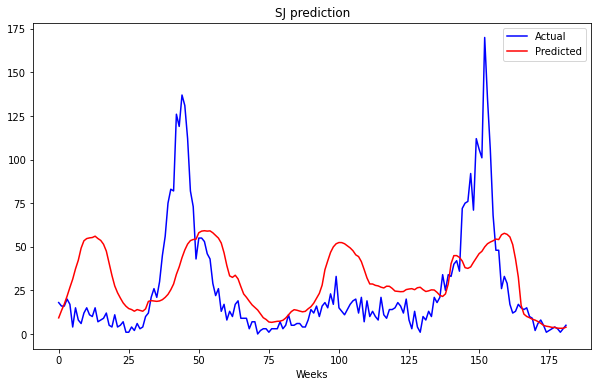

In [176]:
plt.figure(figsize=(10,6))
plt.plot(test_y, color='blue', label='Actual')
plt.plot(pred , color='red', label='Predicted')
plt.title('SJ prediction')
plt.xlabel('Weeks')
plt.legend()
plt.show()

## Submission for SJ

In [177]:
sj_test = scaler.fit_transform(sj_test)
sj_test = create_lag(sj_test,50)
sj_test = np.array(sj_test)
sj_test = np.reshape(sj_test, (sj_test.shape[0], 50, 4))

test_pred = model.predict(sj_test)

# test_pred_form = np.zeros(shape=(len(test_pred), 9) )
# test_pred_form[:,0] = test_pred[:,0]
# test_pred = scaler.inverse_transform(test_pred_form)[:,0]

test_pred_df=pd.DataFrame(test_pred).round().clip(lower=0).astype(int)
test_pred = test_pred_df.loc[:,0]

In [178]:
#IQ

In [179]:
print(iq_train.shape)
print(iq_test.shape)
print(iq_labels.shape)

(495, 6)
(156, 6)
(495, 2)


In [180]:
iq_y = iq_labels[["total_cases"]].values
iq_x = iq_train.drop(["weekofyear","week_start_date"], axis= 1).values
iq_test = iq_test.drop(["weekofyear","week_start_date"], axis = 1).values


In [181]:
train_x, test_x, train_y, test_y = train_test_split(iq_x, iq_y, test_size = 0.2, shuffle = False)

In [182]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)

In [183]:
train_x = create_lag(train_x,1)
test_x = create_lag(test_x,1)


train_x = np.array(train_x)
test_x = np.array(test_x)

train_x = np.reshape(train_x, (train_x.shape[0], 1,4))
test_x = np.reshape(test_x, (test_x.shape[0], 1, 4))

In [184]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(train_y.shape)


(396, 1, 4)
(99, 1, 4)
(396, 1)
(396, 1)


In [185]:
epochs = 50
n_hidden = 40
activation = 'linear'

In [186]:
model2 = Sequential()
model2.add(LSTM(n_hidden, input_shape=((1,4))))

model2.add(Dense(n_hidden))

model2.add(Dense(1))

model2.compile(loss='mae', optimizer='adam', metrics = ['mean_absolute_error'])
model2_final = model2.fit(train_x,train_y,validation_data = (test_x,test_y), epochs=epochs, batch_size=72, shuffle=False)


Epoch 1/50
6/6 [==============================] - 3s 123ms/step - loss: 7.3218 - mean_absolute_error: 7.3218 - val_loss: 9.7835 - val_mean_absolute_error: 9.7835
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 7.2446 - mean_absolute_error: 7.2446 - val_loss: 9.6741 - val_mean_absolute_error: 9.6741
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 7.1608 - mean_absolute_error: 7.1608 - val_loss: 9.5498 - val_mean_absolute_error: 9.5498
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 7.0652 - mean_absolute_error: 7.0652 - val_loss: 9.4049 - val_mean_absolute_error: 9.4049
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 6.9527 - mean_absolute_error: 6.9527 - val_loss: 9.2319 - val_mean_absolute_error: 9.2319
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 6.8181 - mean_absolute_error: 6.8181 - val_loss: 9.0297 - val_mean_absolute_error: 9.0297
Epoch 7/50
6/6 [======================

## Predicting for IQ

In [187]:
pred2 = model2.predict(test_x)


# pred2_form = np.zeros(shape=(len(pred2), 11) )
# pred2_form[:,0] = pred2[:,0]
# pred2 = scaler.inverse_transform(pred2_form)[:,0]

## Analysing for IQ

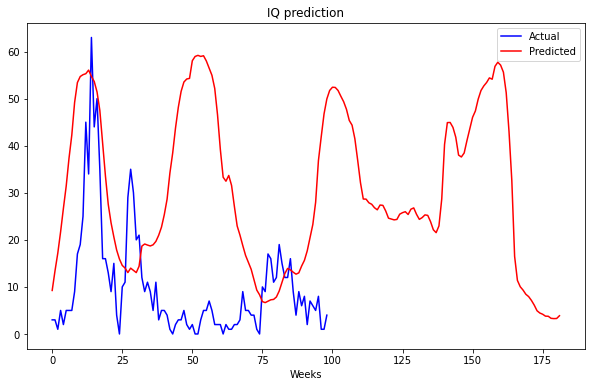

In [188]:
plt.figure(figsize=(10,6))
plt.plot(test_y, color='blue', label='Actual')
plt.plot(pred , color='red', label='Predicted')
plt.title('IQ prediction')
plt.xlabel('Weeks')
plt.legend()
plt.show()

## Submission for IQ

In [189]:
iq_test = scaler.fit_transform(iq_test)
iq_test = create_lag(iq_test,1)
iq_test = np.array(iq_test)
iq_test = np.reshape(iq_test, (iq_test.shape[0], 1, 4))

test_pred_iq = model2.predict(iq_test)

In [190]:
test_pred_df_iq=pd.DataFrame(test_pred_iq).round().clip(lower=0).astype(int)
test_pred_iq = test_pred_df_iq.loc[:,0]

In [191]:
# pred = pd.concat([test_pred, test_pred_iq], ignore_index=True).round().clip(lower=0).astype(int)
# pred.to_csv('predictionNN.csv', index=False)
# pred=np.concatenate([test_pred, test_pred_iq])


In [192]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([test_pred, test_pred_iq])



print (submission)

# submission.iloc[:9]=8
# submission.iloc[:8]=9
# submission.iloc[:7]=7
# submission.iloc[:6]=7
# submission.iloc[:5]=6
# submission.iloc[:4]=8
# submission.iloc[:3]=8
# submission.iloc[:2]=7
# submission.iloc[:1]=6

                      total_cases
city year weekofyear             
sj   2008 18                    2
          19                    2
          20                    2
          21                    3
          22                    4
...                           ...
iq   2013 22                    5
          23                    5
          24                    4
          25                    4
          26                    4

[416 rows x 1 columns]


In [193]:
submission.to_csv("ResultsNN.csv")

In [194]:
submission

total_cases
city year weekofyear             
sj   2008 18                    2
          19                    2
          20                    2
          21                    3
          22                    4
...                           ...
iq   2013 22                    5
          23                    5
          24                    4
          25                    4
          26                    4

[416 rows x 1 columns]

## Result

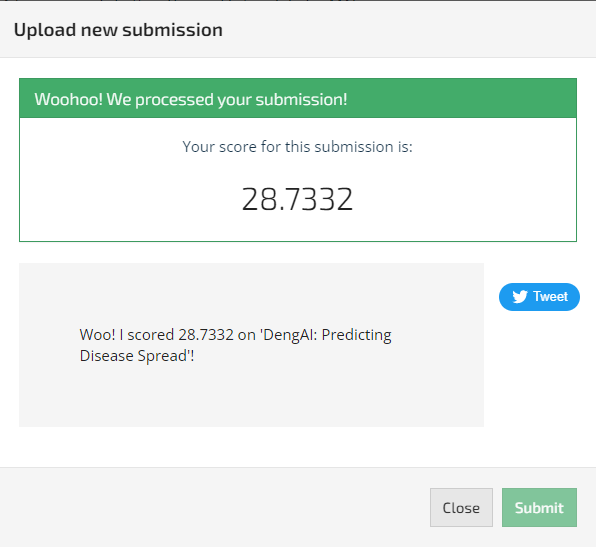